In [1]:
# Requirements
# pip install pandas numpy matplotlib seaborn scipy scikit-learn missingno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

sns.set(style='whitegrid', context='notebook', font_scale=1.0)
plt.rcParams['figure.figsize'] = (10,5)

# Load dataset (adjust path as needed)
df = pd.read_csv('/kaggle/input/bank-marketing/bank-additional-full.csv', sep=',')
df_original = df.copy()
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


,dtype,n_unique,n_missing
age,int64,78,0
job,object,12,0
marital,object,4,0
education,object,8,0
default,object,3,0
housing,object,3,0
loan,object,3,0
contact,object,2,0
month,object,10,0
day_of_week,object,5,0


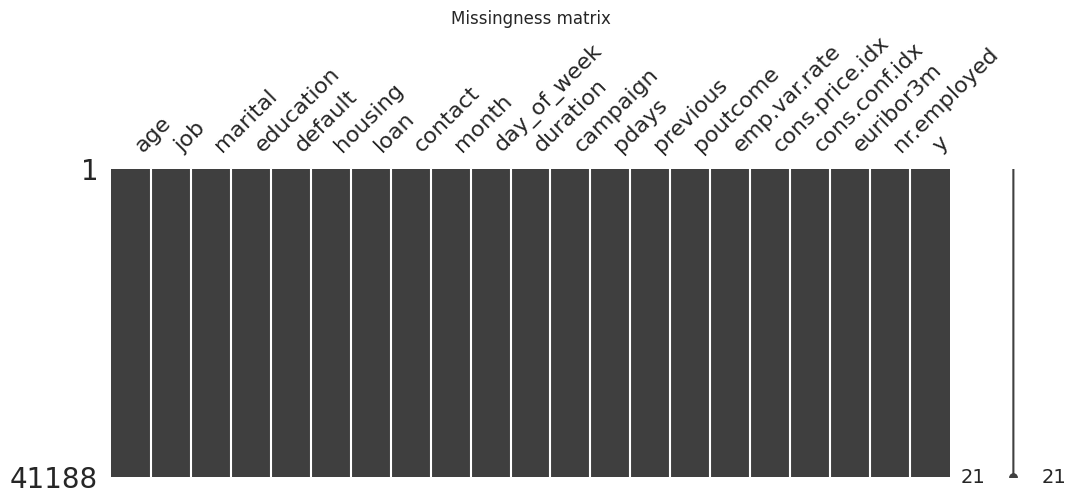

In [2]:
# Data types and counts
dtype_table = pd.DataFrame({
    'dtype': df.dtypes,
    'n_unique': df.nunique(),
    'n_missing': df.isna().sum()
})
display(dtype_table)

# Visualize missingness
msno.matrix(df, figsize=(12,4))
plt.title('Missingness matrix')
plt.show()


Conversion summary (non-numeric values coerced to NaN):
  age: 0 / 41188 non-numeric or missing
  duration: 0 / 41188 non-numeric or missing
  campaign: 0 / 41188 non-numeric or missing
  pdays: 0 / 41188 non-numeric or missing
  previous: 0 / 41188 non-numeric or missing
  emp.var.rate: 0 / 41188 non-numeric or missing
  cons.price.idx: 0 / 41188 non-numeric or missing
  cons.conf.idx: 0 / 41188 non-numeric or missing
  euribor3m: 0 / 41188 non-numeric or missing
  nr.employed: 0 / 41188 non-numeric or missing
Detected pdays==999 sentinel: created no_prior_contact and pdays_clean.


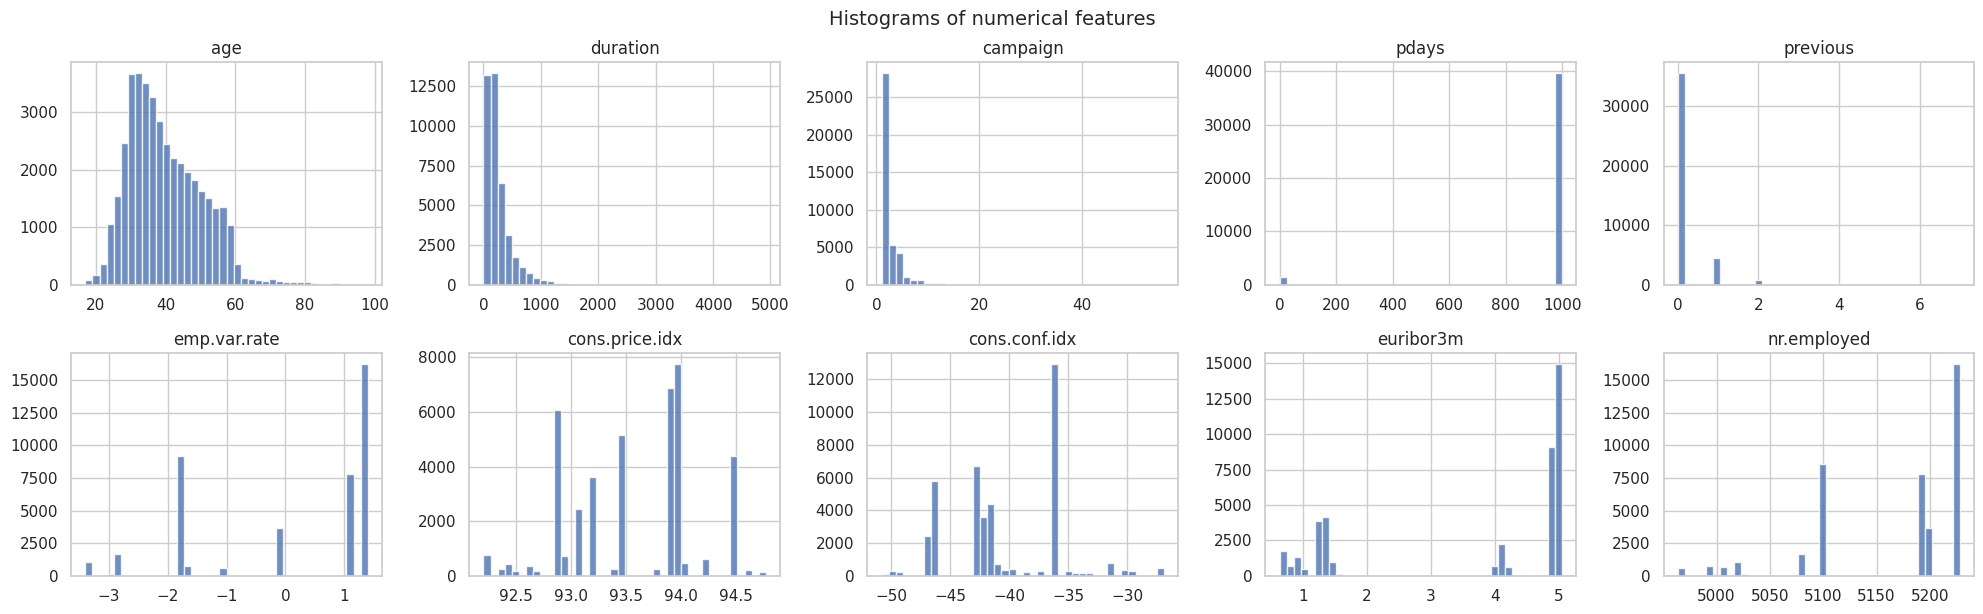

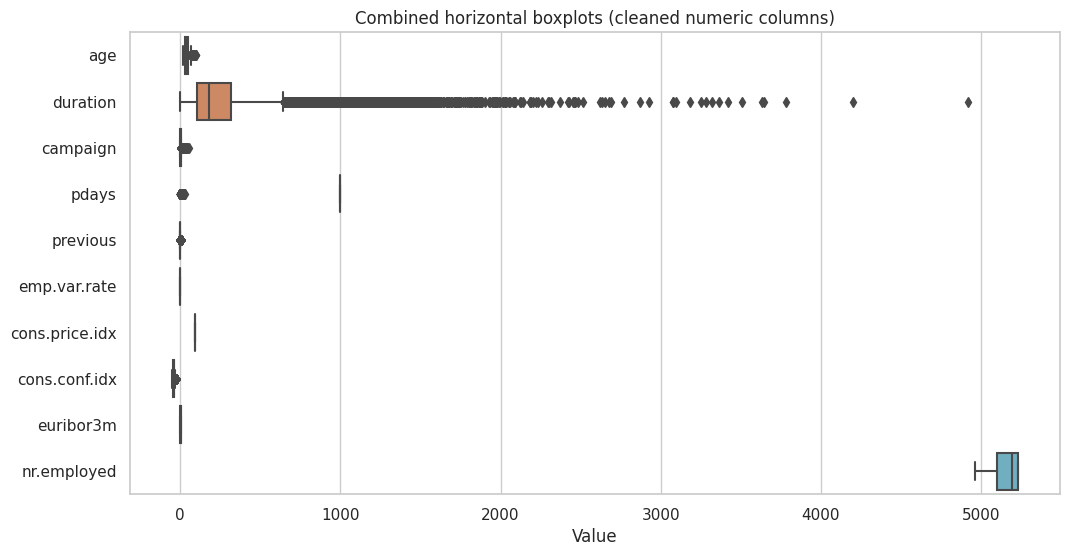

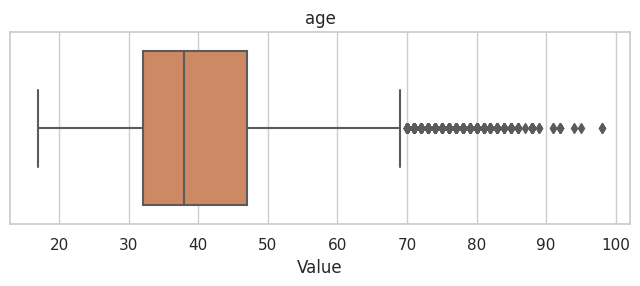

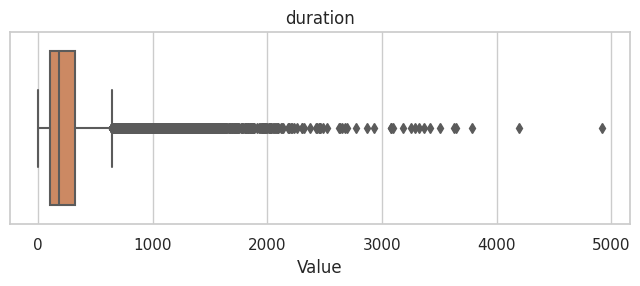

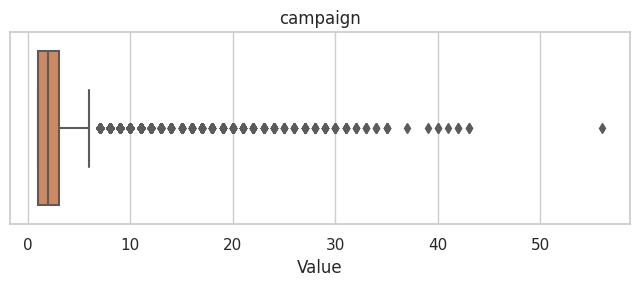

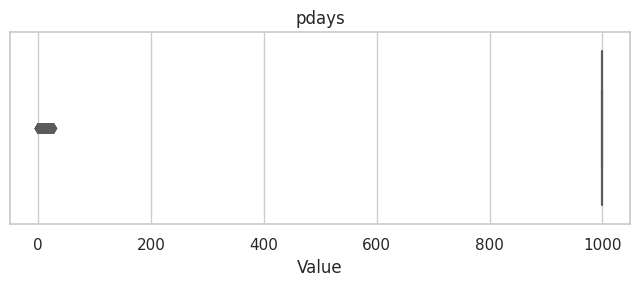

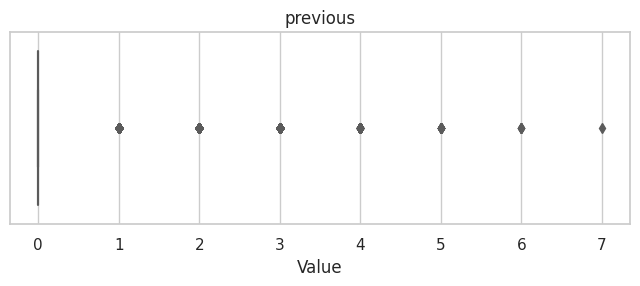

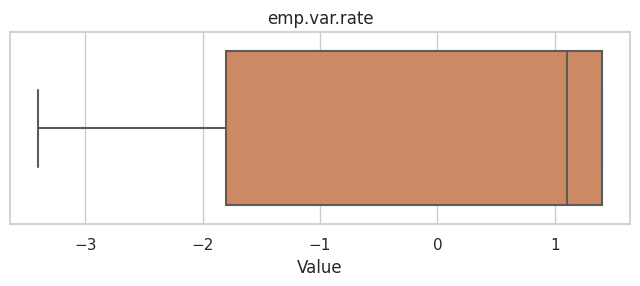

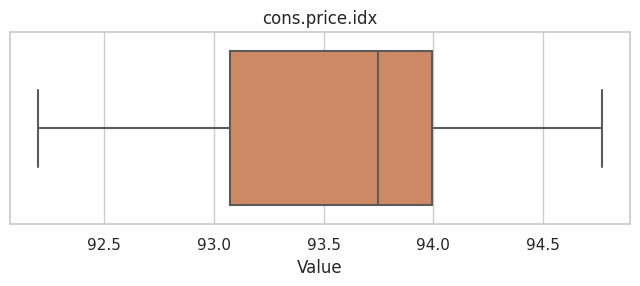

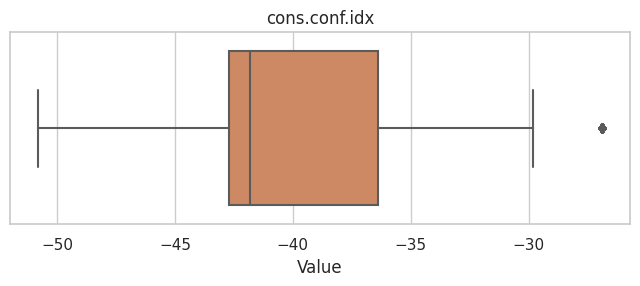

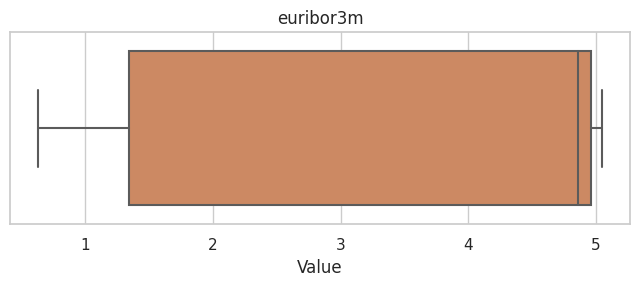

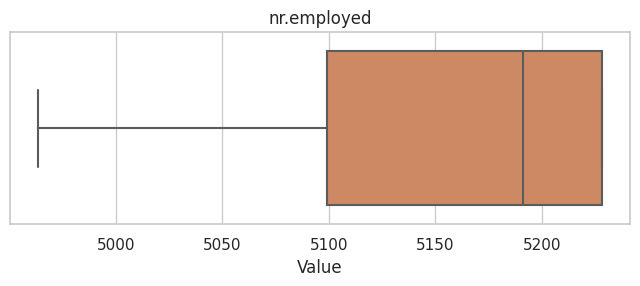

In [5]:
# Requirements: pandas numpy matplotlib seaborn
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook', font_scale=1.0)
plt.rcParams['figure.figsize'] = (12, 5)

# Example: df already loaded
# num_cols as provided by you
num_cols = ['age','duration','campaign','pdays','previous',
            'emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

# 1) Safe numeric conversion function
def to_numeric_safe(series):
    # Remove commas, strip whitespace, coerce errors to NaN
    s = series.astype(str).str.replace(',', '', regex=False).str.strip()
    return pd.to_numeric(s, errors='coerce')

# 2) Convert and report
conversion_report = {}
for c in num_cols:
    df[c + '_num'] = to_numeric_safe(df[c])
    n_total = len(df)
    n_na = df[c + '_num'].isna().sum()
    n_non_numeric = n_na
    conversion_report[c] = {'total': n_total, 'non_numeric_after_coerce': n_non_numeric}
    
# Print conversion summary
print('Conversion summary (non-numeric values coerced to NaN):')
for k,v in conversion_report.items():
    print(f"  {k}: {v['non_numeric_after_coerce']} / {v['total']} non-numeric or missing")

# 3) Special handling for pdays sentinel (common in this dataset)
# If pdays uses 999 to indicate "no prior contact", create indicator and cleaned pdays
if 'pdays_num' in df.columns:
    # detect if 999 appears frequently
    unique_pdays = df['pdays_num'].dropna().unique()
    if 999 in unique_pdays:
        df['no_prior_contact'] = (df['pdays_num'] == 999).astype(int)
        df['pdays_clean'] = df['pdays_num'].replace(999, np.nan)
        print('Detected pdays==999 sentinel: created no_prior_contact and pdays_clean.')
    else:
        df['no_prior_contact'] = (df['pdays_num'].isna()).astype(int)
        df['pdays_clean'] = df['pdays_num']

# 4) Histograms with automatic layout
clean_cols = [c + '_num' for c in num_cols]
n = len(clean_cols)
# choose number of columns for subplot grid
ncols = 5  # for 10 plots, 5 columns x 2 rows; adjust if you prefer different shape
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten()
for i, col in enumerate(clean_cols):
    ax = axes[i]
    data = df[col].dropna()
    if data.empty:
        ax.text(0.5, 0.5, 'No numeric data', ha='center', va='center')
        ax.set_title(col.replace('_num',''))
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    ax.hist(data, bins=40, color='C0', alpha=0.8)
    ax.set_title(col.replace('_num',''))
plt.tight_layout()
plt.suptitle('Histograms of numerical features', y=1.02, fontsize=14)
plt.show()

# 5) Combined horizontal boxplot (useful when scales differ)
plt.figure(figsize=(12,6))
# select columns that have at least some numeric values
valid_cols = [c for c in clean_cols if df[c].dropna().size > 0]
sns.boxplot(data=df[valid_cols], orient='h')
plt.yticks(ticks=range(len(valid_cols)), labels=[c.replace('_num','') for c in valid_cols])
plt.title('Combined horizontal boxplots (cleaned numeric columns)')
plt.xlabel('Value')
plt.show()

# 6) Individual boxplots (one per figure) using dropna()
for col in valid_cols:
    plt.figure(figsize=(8,2.5))
    sns.boxplot(x=df[col].dropna(), color='C1')
    plt.title(col.replace('_num',''))
    plt.xlabel('Value')
    plt.show()


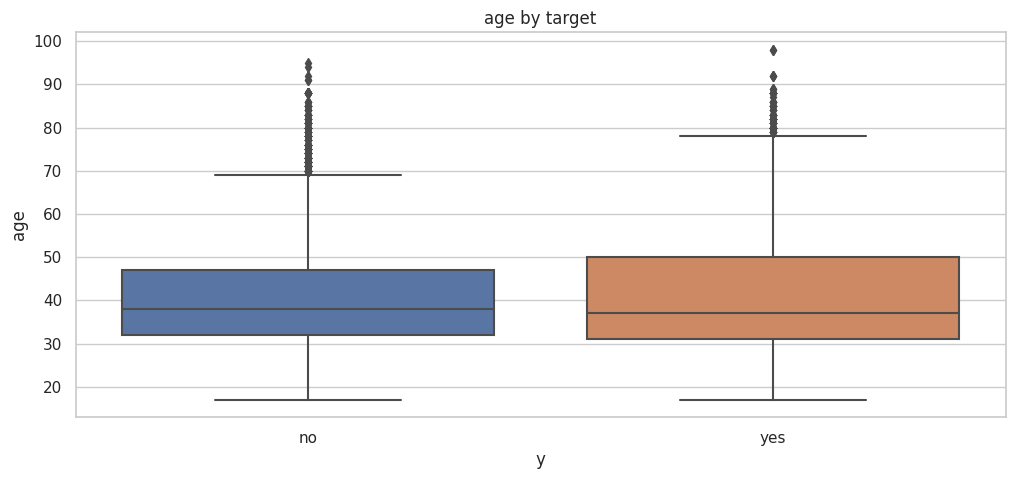

age t-test p-value: 1.805e-06


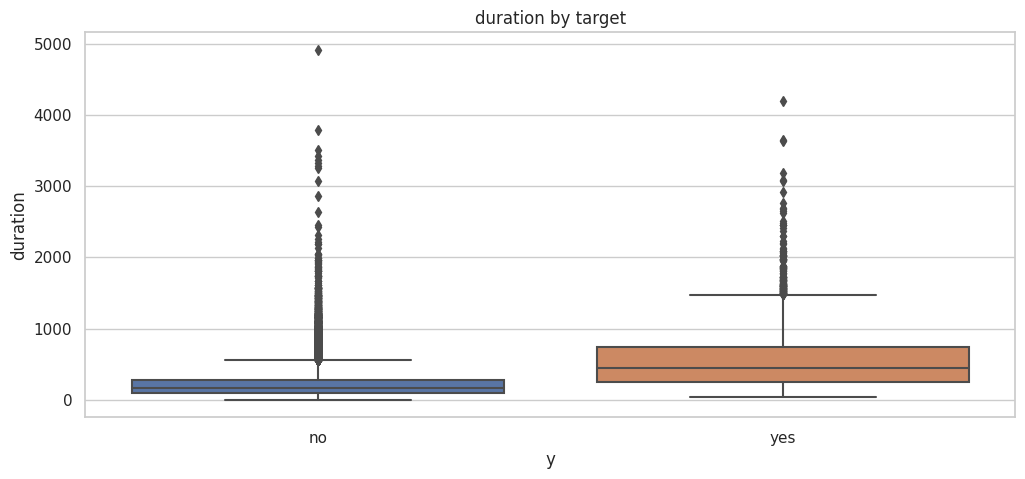

duration t-test p-value: 0.000e+00


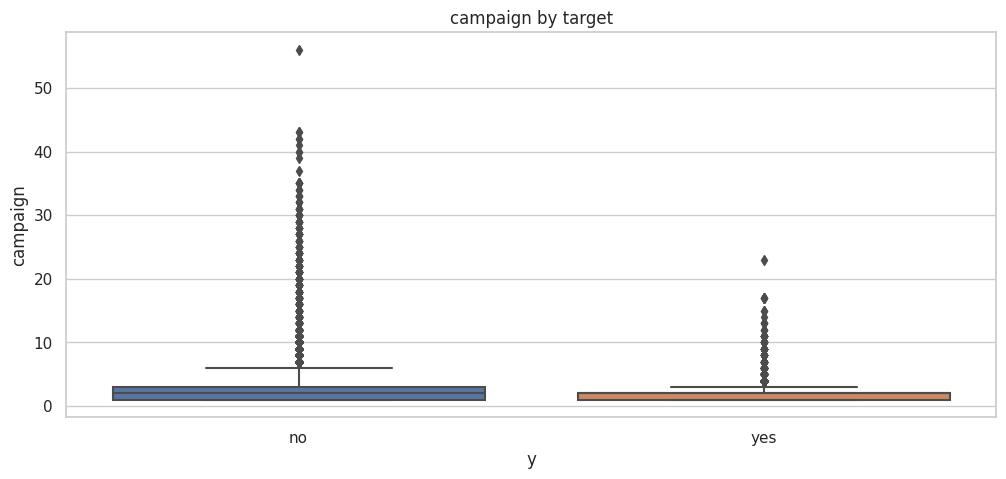

campaign t-test p-value: 4.100e-89


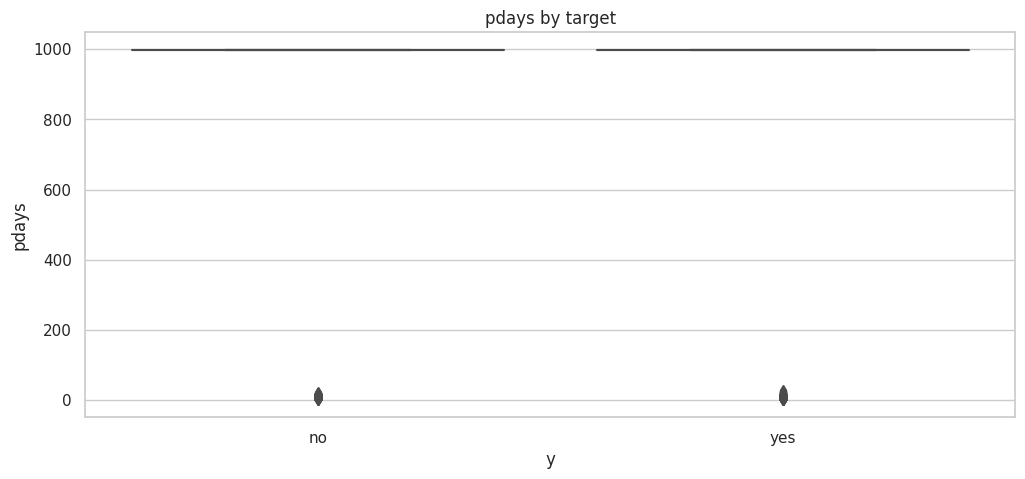

pdays t-test p-value: 1.663e-206


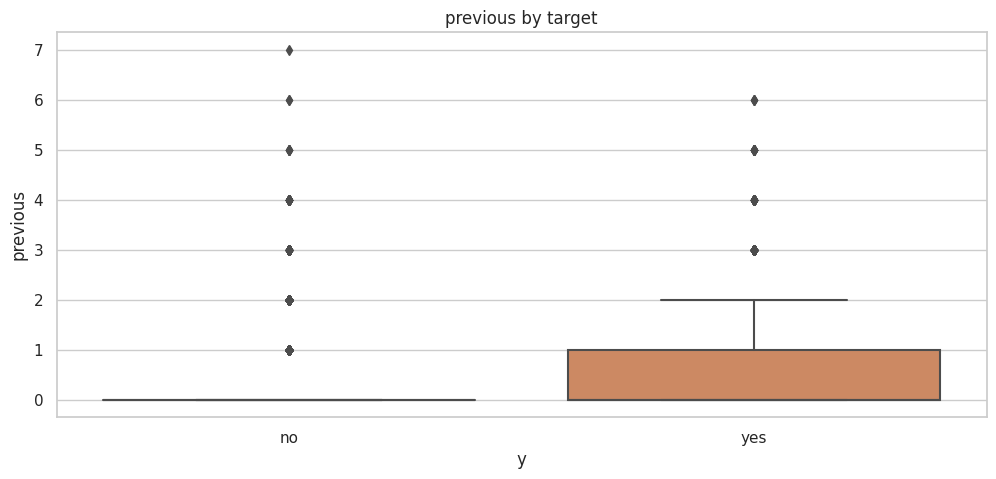

previous t-test p-value: 1.676e-161


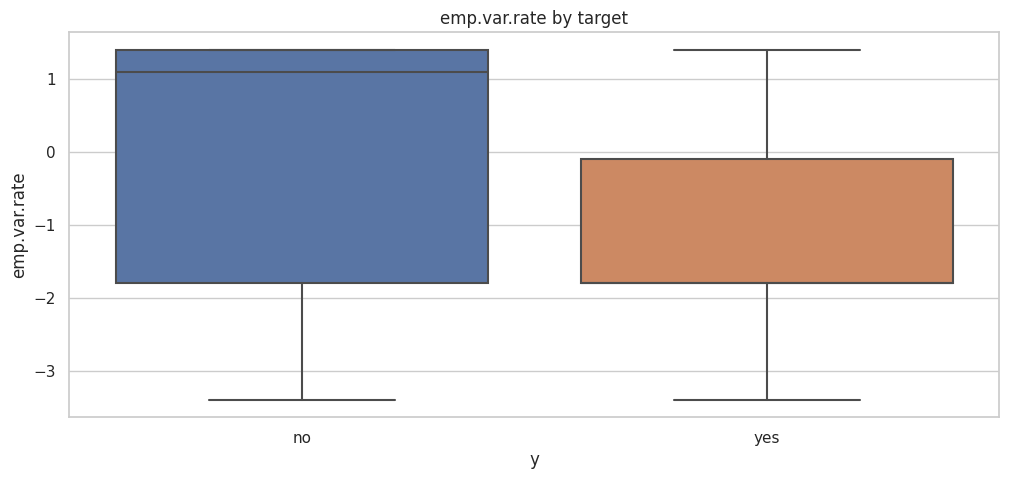

emp.var.rate t-test p-value: 0.000e+00


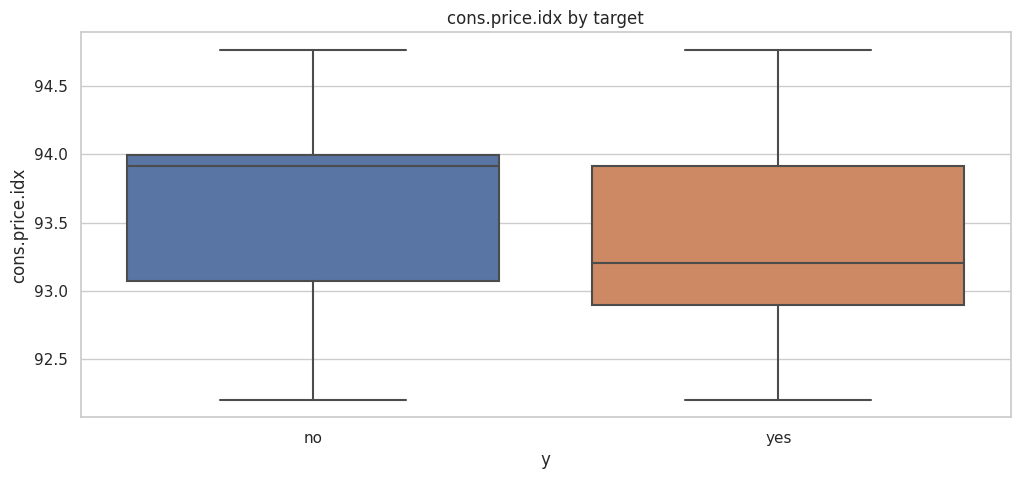

cons.price.idx t-test p-value: 6.917e-122


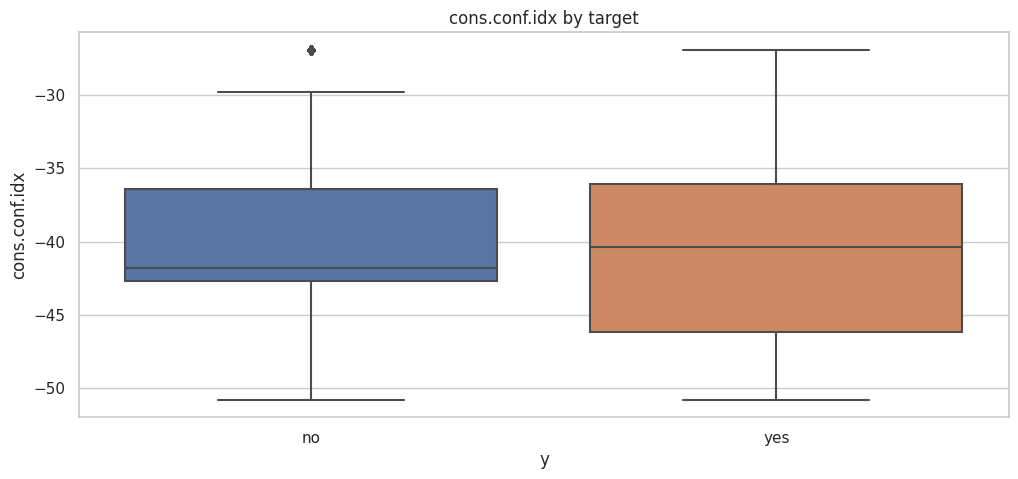

cons.conf.idx t-test p-value: 7.588e-18


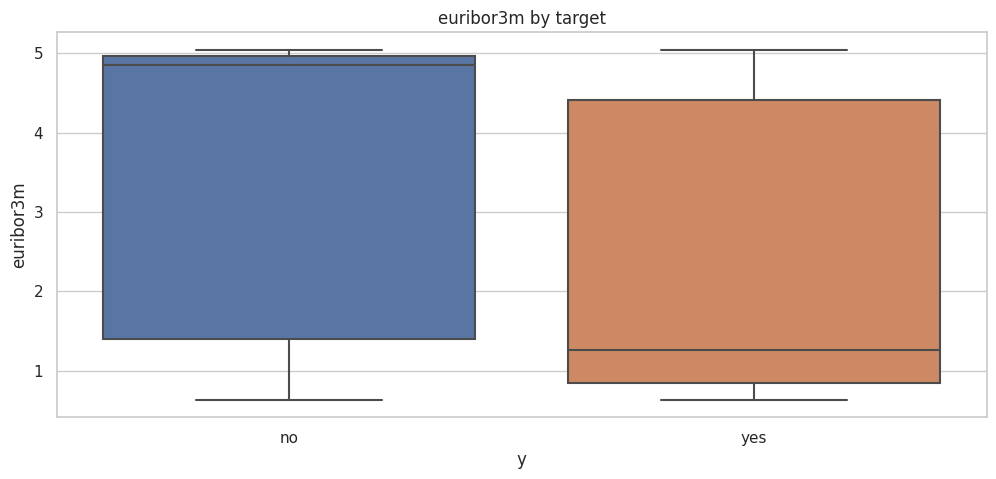

euribor3m t-test p-value: 0.000e+00


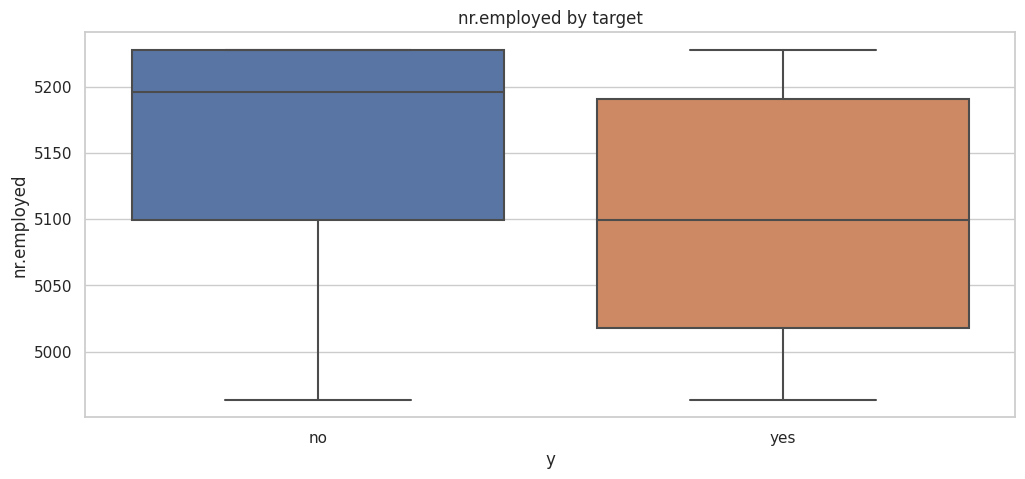

nr.employed t-test p-value: 0.000e+00

Top conversion rates for job:
 job
student          0.314286
retired          0.252326
unemployed       0.142012
admin.           0.129726
management       0.112175
unknown          0.112121
technician       0.108260
self-employed    0.104856
housemaid        0.100000
entrepreneur     0.085165
Name: y_bin, dtype: float64


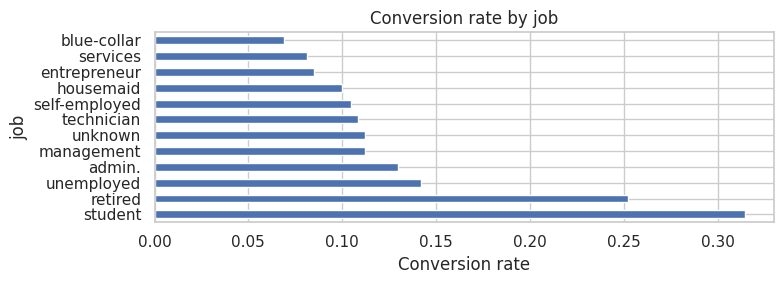


Top conversion rates for marital:
 marital
unknown     0.150000
single      0.140041
divorced    0.103209
married     0.101573
Name: y_bin, dtype: float64


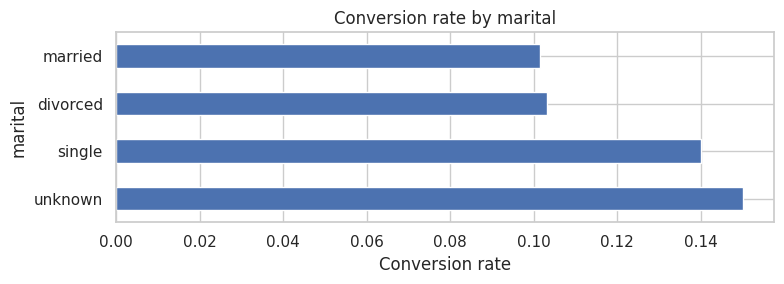


Top conversion rates for education:
 education
illiterate             0.222222
unknown                0.145003
university.degree      0.137245
professional.course    0.113485
high.school            0.108355
basic.4y               0.102490
basic.6y               0.082024
basic.9y               0.078246
Name: y_bin, dtype: float64


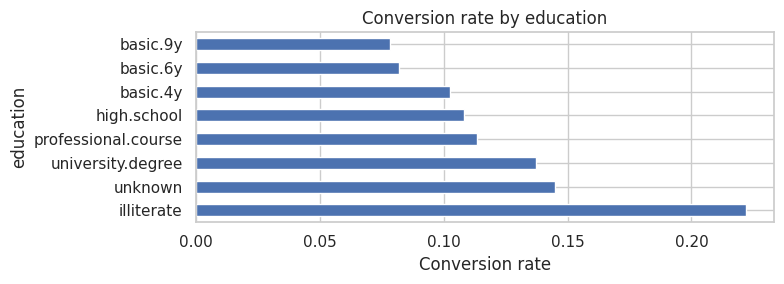


Top conversion rates for default:
 default
no         0.12879
unknown    0.05153
yes        0.00000
Name: y_bin, dtype: float64


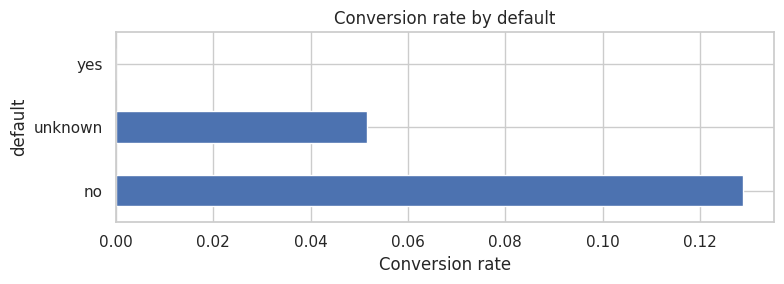


Top conversion rates for housing:
 housing
yes        0.116194
no         0.108796
unknown    0.108081
Name: y_bin, dtype: float64


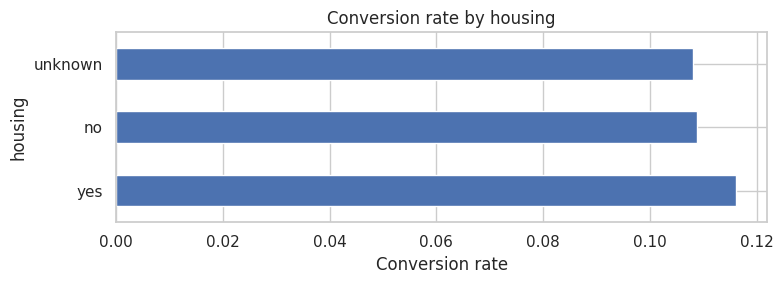


Top conversion rates for loan:
 loan
no         0.113402
yes        0.109315
unknown    0.108081
Name: y_bin, dtype: float64


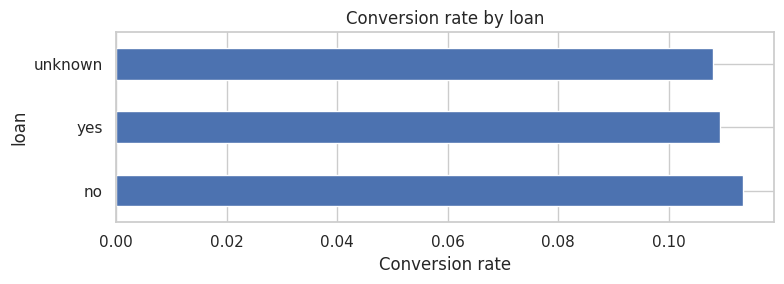


Top conversion rates for contact:
 contact
cellular     0.147376
telephone    0.052313
Name: y_bin, dtype: float64


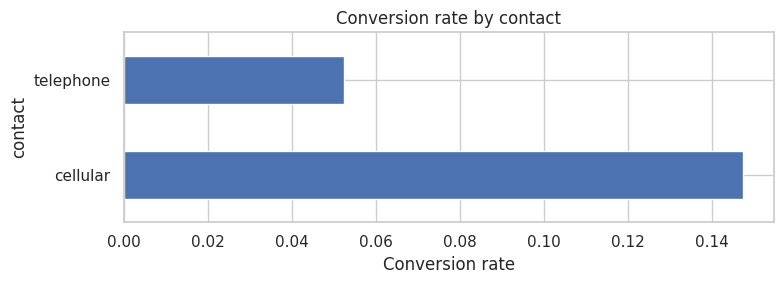


Top conversion rates for month:
 month
mar    0.505495
dec    0.489011
sep    0.449123
oct    0.438719
apr    0.204787
aug    0.106021
jun    0.105115
nov    0.101439
jul    0.090466
may    0.064347
Name: y_bin, dtype: float64


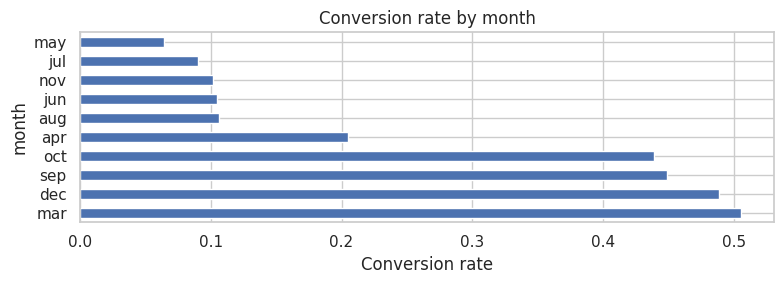


Top conversion rates for day_of_week:
 day_of_week
thu    0.121188
tue    0.117800
wed    0.116671
fri    0.108087
mon    0.099483
Name: y_bin, dtype: float64


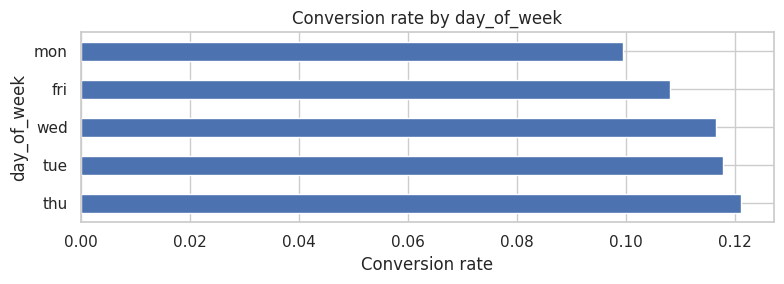


Top conversion rates for poutcome:
 poutcome
success        0.651129
failure        0.142286
nonexistent    0.088322
Name: y_bin, dtype: float64


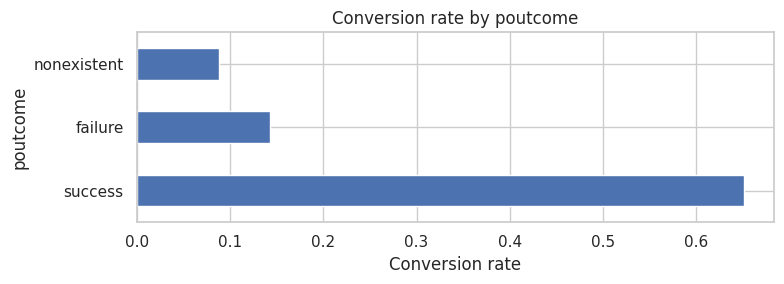


Top conversion rates for age_num:
 age_num
98    1.000000
89    1.000000
87    1.000000
92    0.750000
77    0.650000
82    0.647059
86    0.625000
80    0.580645
76    0.529412
65    0.522727
Name: y_bin, dtype: float64


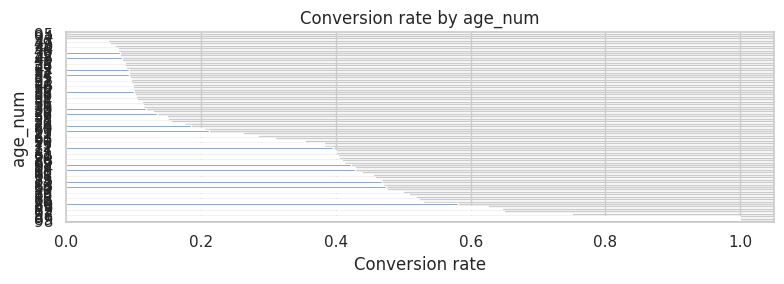


Top conversion rates for duration_num:
 duration_num
998     1.0
949     1.0
830     1.0
1613    1.0
959     1.0
1227    1.0
1228    1.0
1817    1.0
817     1.0
1232    1.0
Name: y_bin, dtype: float64


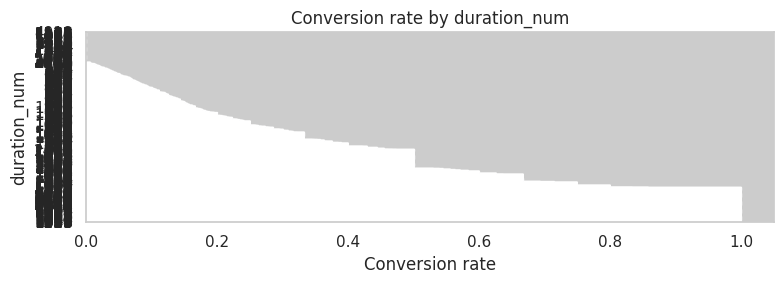


Top conversion rates for campaign_num:
 campaign_num
1     0.130371
2     0.114570
3     0.107471
4     0.093927
6     0.076609
5     0.075047
17    0.068966
11    0.067797
23    0.062500
7     0.060413
Name: y_bin, dtype: float64


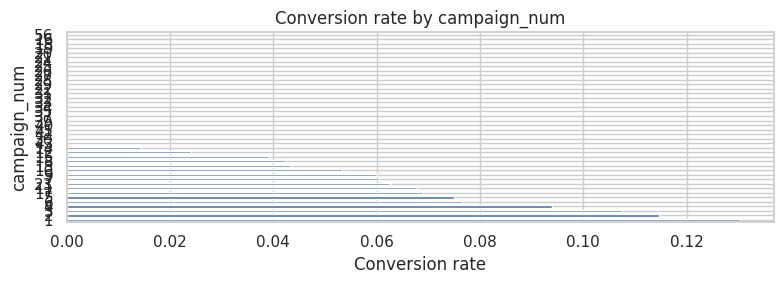


Top conversion rates for pdays_num:
 pdays_num
27    1.000000
26    1.000000
25    1.000000
21    1.000000
13    0.777778
6     0.701456
3     0.678815
15    0.666667
22    0.666667
0     0.666667
Name: y_bin, dtype: float64


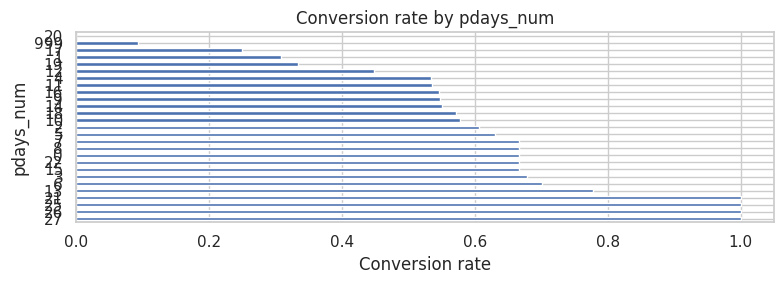


Top conversion rates for previous_num:
 previous_num
5    0.722222
6    0.600000
3    0.592593
4    0.542857
2    0.464191
1    0.212015
0    0.088322
7    0.000000
Name: y_bin, dtype: float64


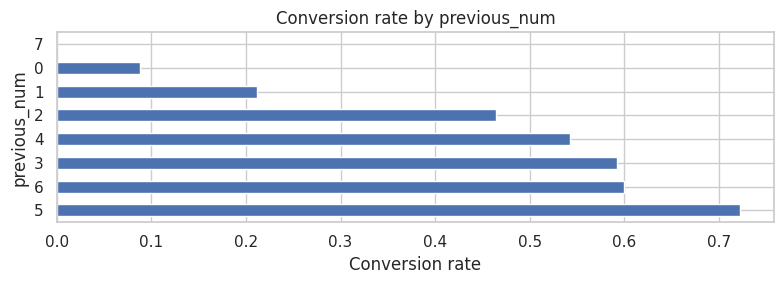


Top conversion rates for emp.var.rate_num:
 emp.var.rate_num
-1.7    0.521345
-3.0    0.511628
-1.1    0.474016
-3.4    0.423903
-2.9    0.357186
-1.8    0.159081
-0.2    0.100000
-0.1    0.062992
 1.4    0.053345
 1.1    0.030916
Name: y_bin, dtype: float64


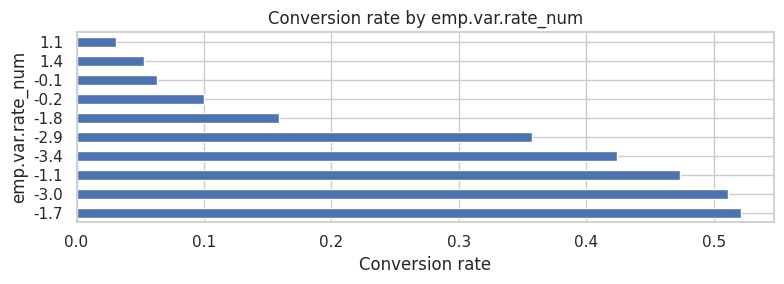


Top conversion rates for cons.price.idx_num:
 cons.price.idx_num
93.798    0.626866
93.876    0.575472
93.369    0.568182
94.215    0.565916
93.749    0.557471
94.027    0.515021
92.713    0.511628
94.199    0.495050
92.649    0.470588
94.055    0.467249
Name: y_bin, dtype: float64


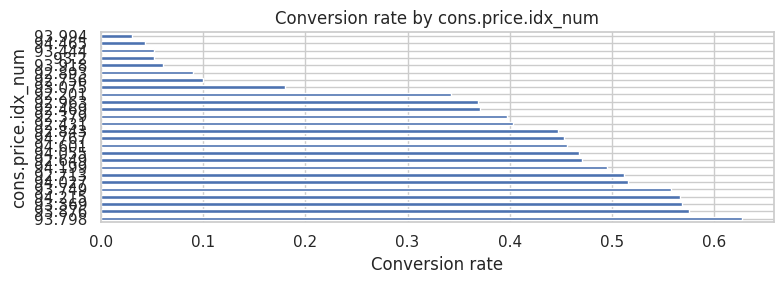


Top conversion rates for cons.conf.idx_num:
 cons.conf.idx_num
-40.4    0.626866
-40.0    0.575472
-34.8    0.568182
-40.3    0.565916
-34.6    0.557471
-38.3    0.515021
-33.0    0.511628
-37.5    0.495050
-30.1    0.470588
-39.8    0.467249
Name: y_bin, dtype: float64


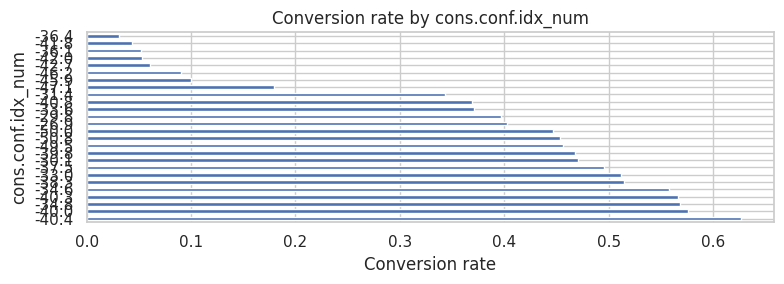


Top conversion rates for euribor3m_num:
 euribor3m_num
3.053    1.000000
0.688    1.000000
0.933    1.000000
0.870    0.923077
0.885    0.900000
0.755    0.857143
4.936    0.833333
0.637    0.833333
1.548    0.833333
0.697    0.826087
Name: y_bin, dtype: float64


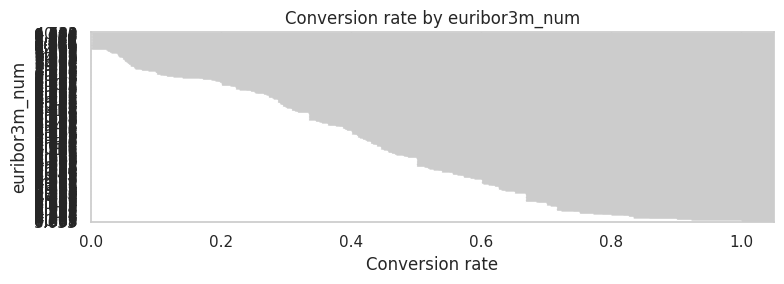


Top conversion rates for nr.employed_num:
 nr.employed_num
5008.7    0.567692
4991.6    0.521345
5023.5    0.511628
4963.6    0.474016
5017.5    0.423903
5076.2    0.357186
5099.1    0.127959
5176.3    0.100000
5195.8    0.062992
5228.1    0.053345
Name: y_bin, dtype: float64


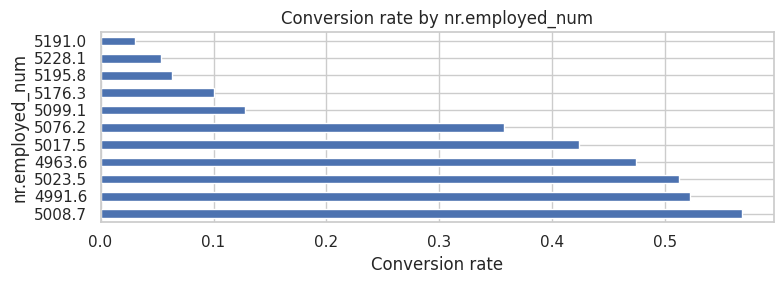


Top conversion rates for no_prior_contact:
 no_prior_contact
0    0.638284
1    0.092582
Name: y_bin, dtype: float64


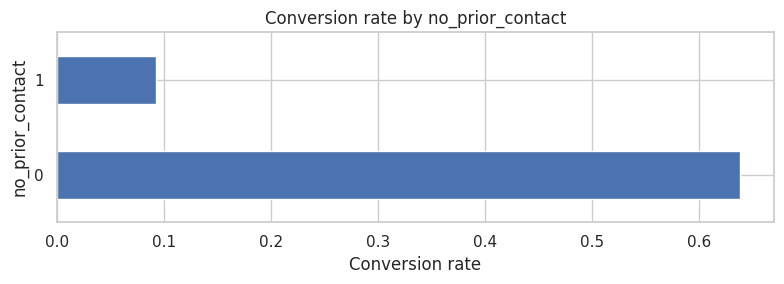


Top conversion rates for pdays_clean:
 pdays_clean
27.0    1.000000
21.0    1.000000
26.0    1.000000
25.0    1.000000
13.0    0.777778
6.0     0.701456
3.0     0.678815
15.0    0.666667
22.0    0.666667
0.0     0.666667
Name: y_bin, dtype: float64


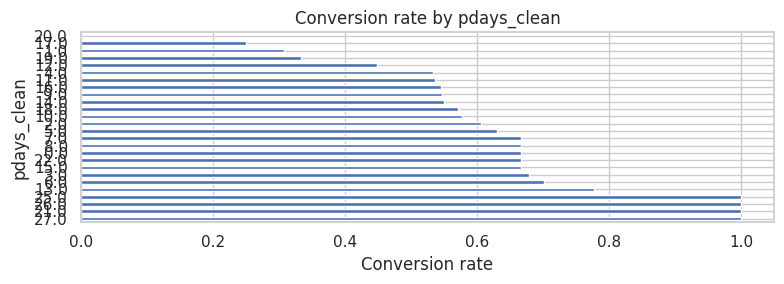

In [6]:
# Convert target to binary for calculations
df['y_bin'] = df['y'].map({'yes':1, 'no':0})

# Numerical vs target: compare distributions and t-tests
for c in num_cols:
    sns.boxplot(x='y', y=c, data=df)
    plt.title(f'{c} by target')
    plt.show()
    # t-test (non-parametric alternative could be used if distributions are non-normal)
    yes_vals = df.loc[df['y']=='yes', c]
    no_vals = df.loc[df['y']=='no', c]
    tstat, pval = stats.ttest_ind(yes_vals, no_vals, equal_var=False)
    print(f'{c} t-test p-value: {pval:.3e}')

# Categorical vs target: conversion rates per category
for c in cat_cols:
    conv = df.groupby(c)['y_bin'].mean().sort_values(ascending=False)
    print(f'\nTop conversion rates for {c}:\n', conv.head(10))
    plt.figure(figsize=(8,3))
    conv.plot(kind='barh')
    plt.title(f'Conversion rate by {c}')
    plt.xlabel('Conversion rate')
    plt.tight_layout()
    plt.show()


After conversion, day_of_week has 41188 NaNs (will not plot those).


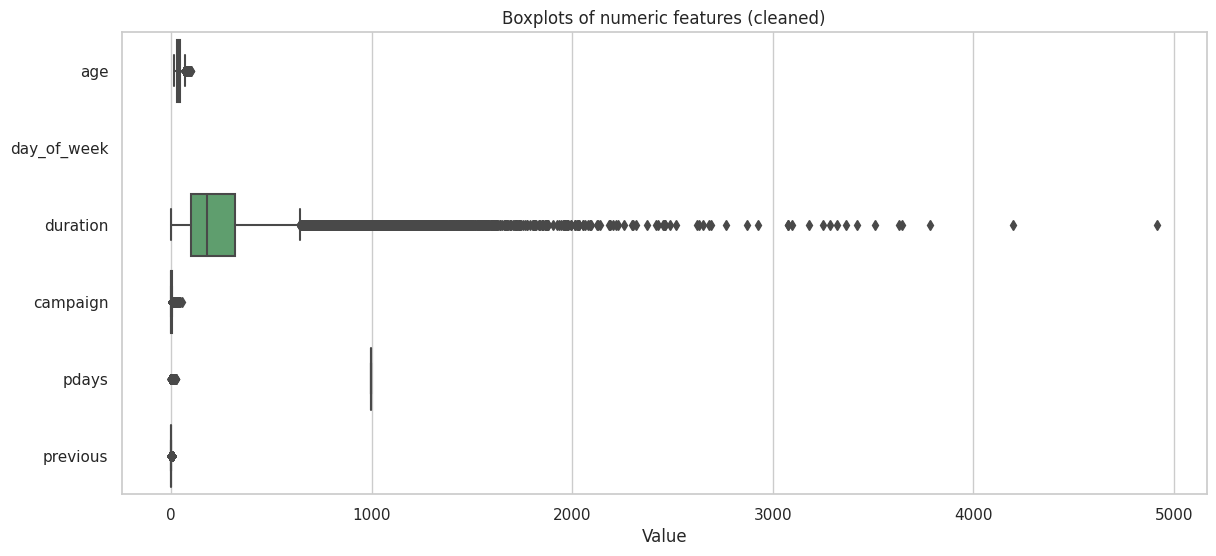

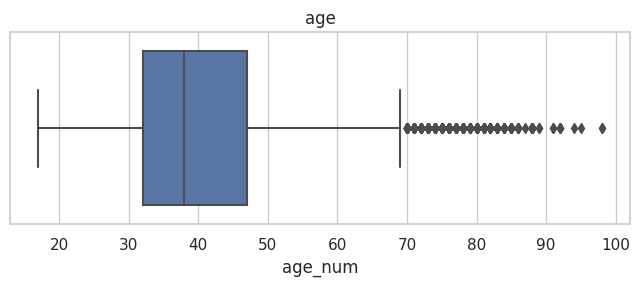

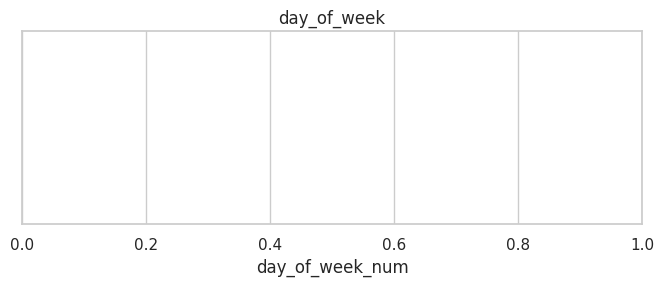

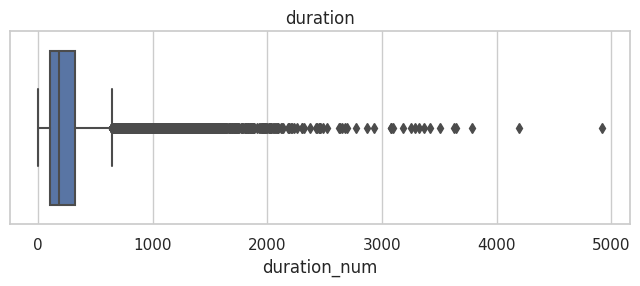

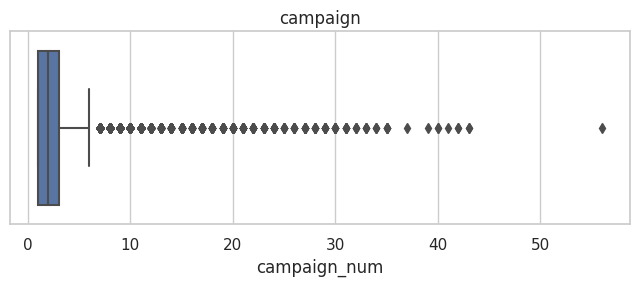

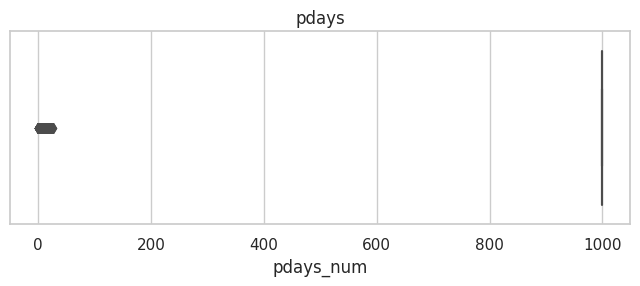

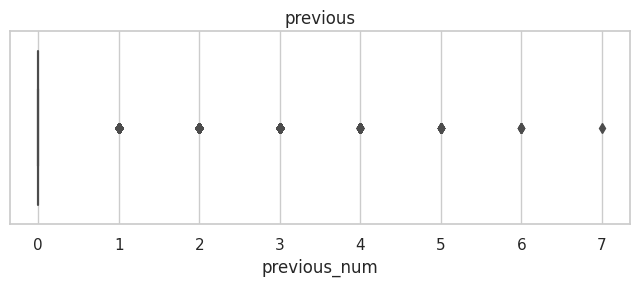

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

def to_numeric_safe(series):
    # Remove commas, strip whitespace, coerce errors to NaN
    s = series.astype(str).str.replace(',', '').str.strip()
    return pd.to_numeric(s, errors='coerce')

# Convert all numeric columns safely
for c in num_cols:
    df[c + '_num'] = to_numeric_safe(df[c])
    n_missing = df[c + '_num'].isna().sum()
    if n_missing:
        print(f'After conversion, {c} has {n_missing} NaNs (will not plot those).')

# Now plot boxplots using the cleaned numeric columns
clean_cols = [c + '_num' for c in num_cols]

# Combined boxplot grid
plt.figure(figsize=(14,6))
sns.boxplot(data=df[clean_cols], orient='h')
plt.title('Boxplots of numeric features (cleaned)')
plt.xlabel('Value')
plt.yticks(ticks=range(len(clean_cols)), labels=num_cols)
plt.show()

# Individual boxplots (one per figure) — useful when scales differ a lot
for c in clean_cols:
    plt.figure(figsize=(8,2.5))
    sns.boxplot(x=df[c].dropna())
    plt.title(c.replace('_num',''))
    plt.show()



job value counts (%):
 job
admin.           25.30
blue-collar      22.47
technician       16.37
services          9.64
management        7.10
retired           4.18
entrepreneur      3.54
self-employed     3.45
housemaid         2.57
unemployed        2.46
student           2.12
unknown           0.80
Name: proportion, dtype: float64


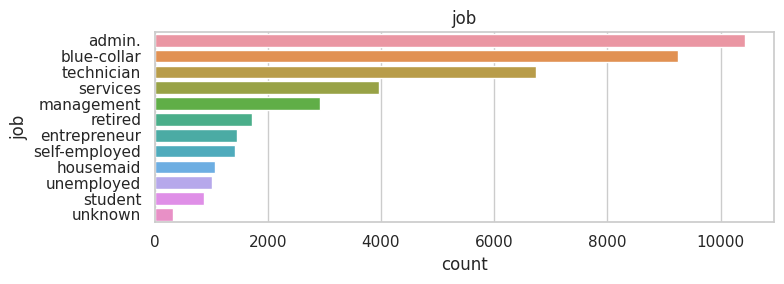


marital value counts (%):
 marital
married     60.52
single      28.09
divorced    11.20
unknown      0.19
Name: proportion, dtype: float64


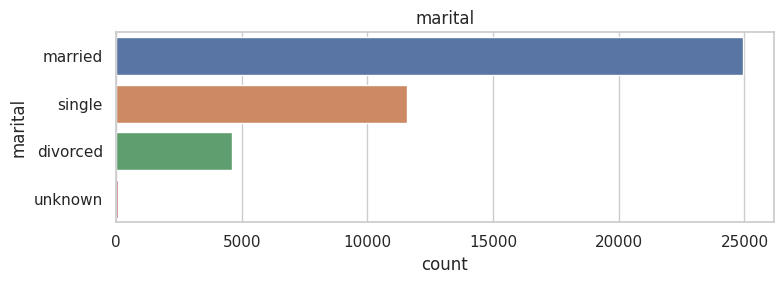


education value counts (%):
 education
university.degree      29.54
high.school            23.10
basic.9y               14.68
professional.course    12.73
basic.4y               10.14
basic.6y                5.56
unknown                 4.20
illiterate              0.04
Name: proportion, dtype: float64


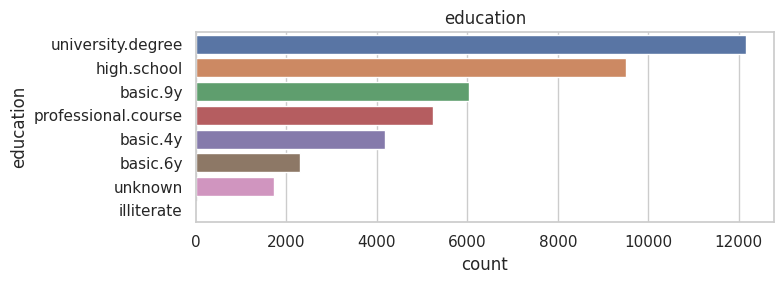


default value counts (%):
 default
no         79.12
unknown    20.87
yes         0.01
Name: proportion, dtype: float64


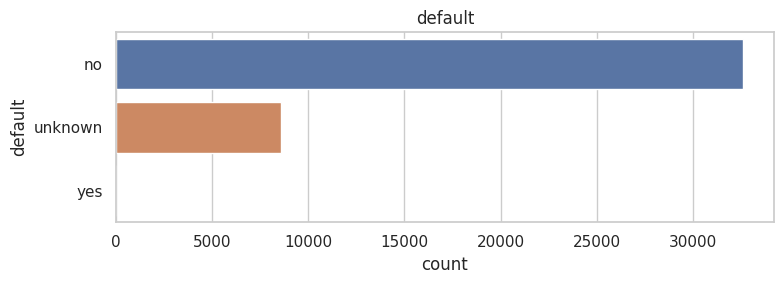


housing value counts (%):
 housing
yes        52.38
no         45.21
unknown     2.40
Name: proportion, dtype: float64


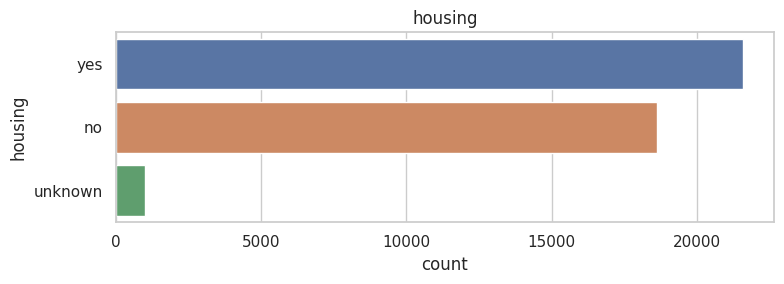


loan value counts (%):
 loan
no         82.43
yes        15.17
unknown     2.40
Name: proportion, dtype: float64


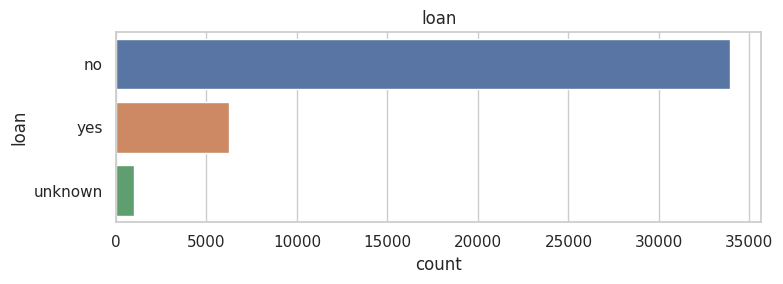


contact value counts (%):
 contact
cellular     63.47
telephone    36.53
Name: proportion, dtype: float64


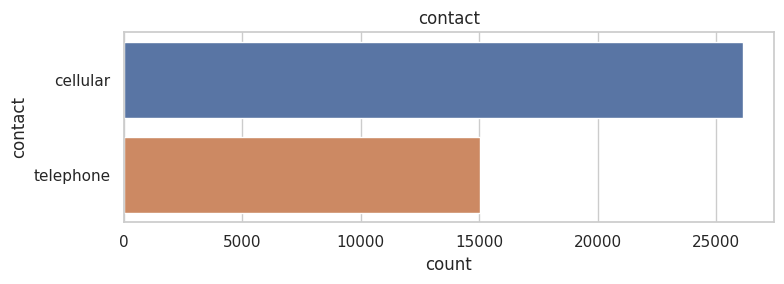


month value counts (%):
 month
may    33.43
jul    17.42
aug    15.00
jun    12.91
nov     9.96
apr     6.39
oct     1.74
sep     1.38
mar     1.33
dec     0.44
Name: proportion, dtype: float64


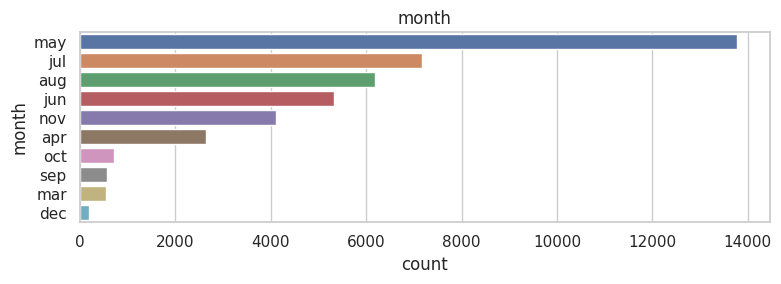


day_of_week value counts (%):
 day_of_week
thu    20.94
mon    20.67
wed    19.75
tue    19.64
fri    19.00
Name: proportion, dtype: float64


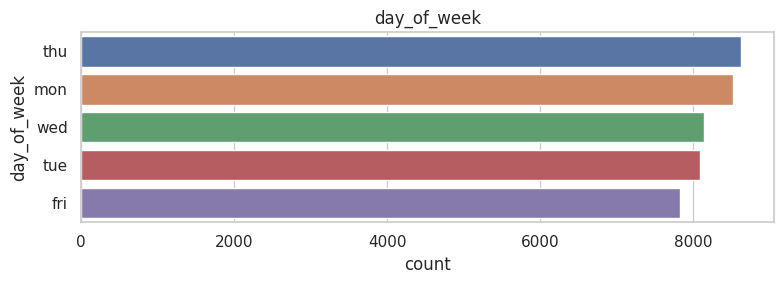


poutcome value counts (%):
 poutcome
nonexistent    86.34
failure        10.32
success         3.33
Name: proportion, dtype: float64


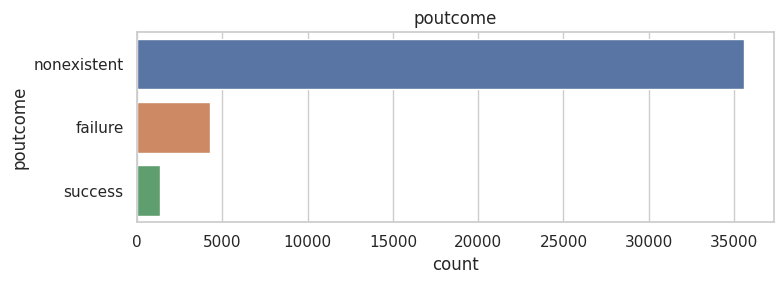


age_num value counts (%):
 age_num
31    4.73
32    4.48
33    4.45
36    4.32
35    4.27
34    4.24
30    4.16
37    3.58
29    3.53
39    3.48
38    3.42
41    3.10
40    2.82
42    2.77
45    2.68
43    2.56
46    2.50
44    2.45
28    2.43
48    2.38
Name: proportion, dtype: float64


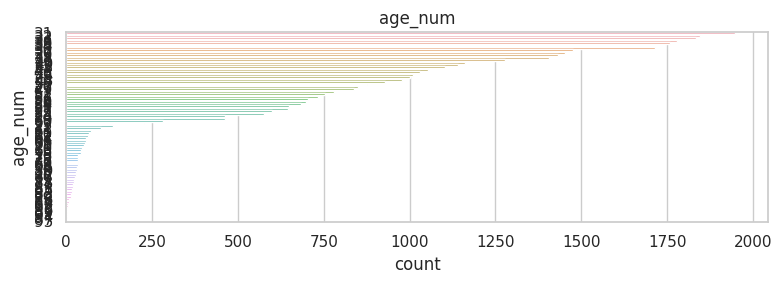


duration_num value counts (%):
 duration_num
90     0.41
85     0.41
136    0.41
73     0.41
124    0.40
87     0.39
72     0.39
104    0.39
111    0.39
106    0.39
97     0.38
109    0.38
122    0.38
114    0.38
135    0.38
92     0.38
119    0.38
96     0.38
139    0.38
82     0.37
Name: proportion, dtype: float64


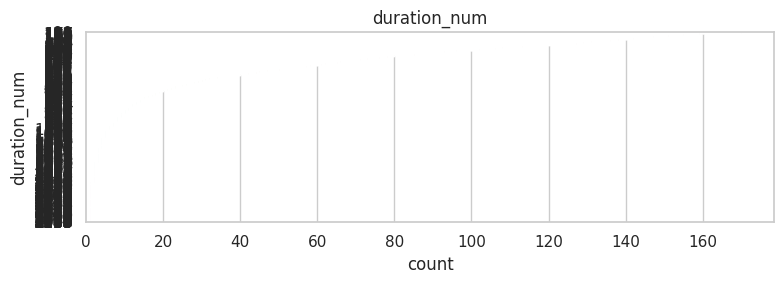


campaign_num value counts (%):
 campaign_num
1     42.83
2     25.66
3     12.97
4      6.44
5      3.88
6      2.38
7      1.53
8      0.97
9      0.69
10     0.55
11     0.43
12     0.30
13     0.22
14     0.17
17     0.14
16     0.12
15     0.12
18     0.08
20     0.07
19     0.06
Name: proportion, dtype: float64


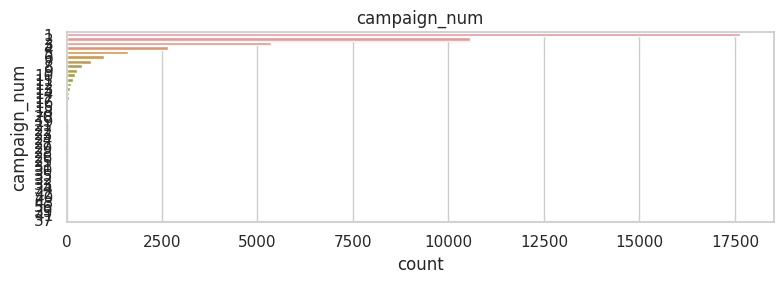


pdays_num value counts (%):
 pdays_num
999    96.32
3       1.07
6       1.00
4       0.29
9       0.16
2       0.15
7       0.15
12      0.14
10      0.13
5       0.11
13      0.09
11      0.07
1       0.06
15      0.06
14      0.05
8       0.04
0       0.04
16      0.03
17      0.02
18      0.02
Name: proportion, dtype: float64


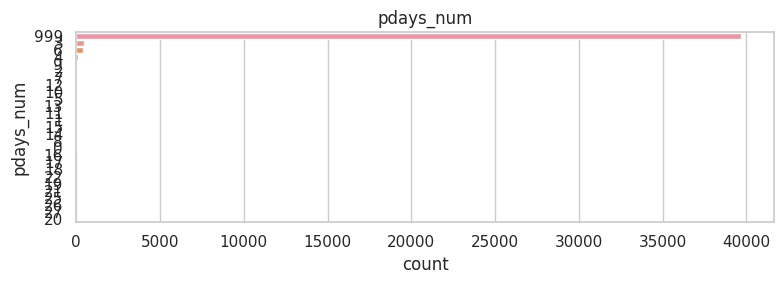


previous_num value counts (%):
 previous_num
0    86.34
1    11.07
2     1.83
3     0.52
4     0.17
5     0.04
6     0.01
7     0.00
Name: proportion, dtype: float64


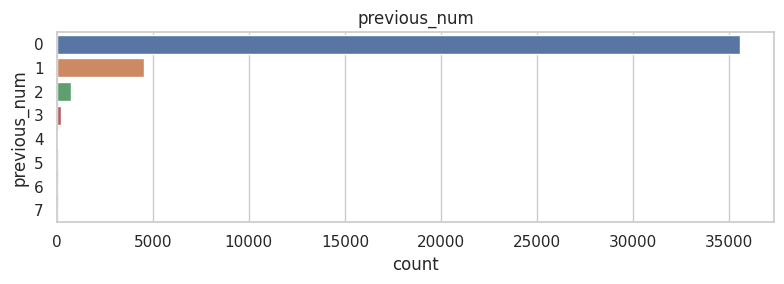


emp.var.rate_num value counts (%):
 emp.var.rate_num
 1.4    39.41
-1.8    22.30
 1.1    18.85
-0.1     8.94
-2.9     4.04
-3.4     2.60
-1.7     1.88
-1.1     1.54
-3.0     0.42
-0.2     0.02
Name: proportion, dtype: float64


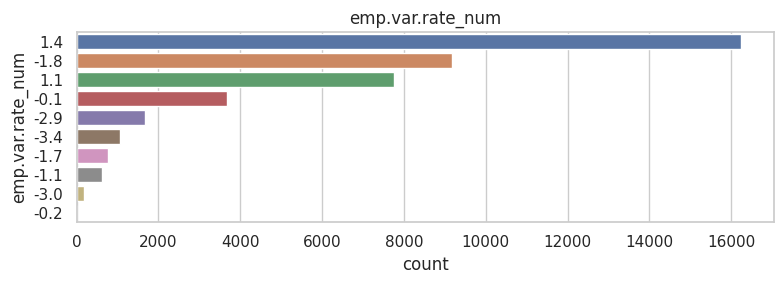


cons.price.idx_num value counts (%):
 cons.price.idx_num
93.994    18.85
93.918    16.23
92.893    14.07
93.444    12.56
94.465    10.62
93.200     8.78
93.075     5.97
92.201     1.87
92.963     1.74
92.431     1.09
92.649     0.87
94.215     0.76
94.199     0.74
92.843     0.68
92.379     0.65
93.369     0.64
94.027     0.57
94.055     0.56
93.876     0.51
94.601     0.50
Name: proportion, dtype: float64


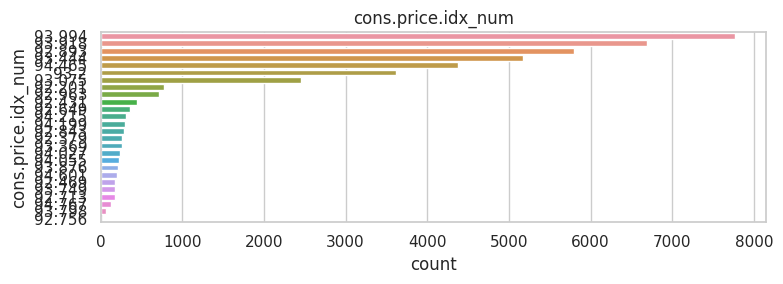


cons.conf.idx_num value counts (%):
 cons.conf.idx_num
-36.4    18.85
-42.7    16.23
-46.2    14.07
-36.1    12.56
-41.8    10.62
-42.0     8.78
-47.1     5.97
-31.4     1.87
-40.8     1.74
-26.9     1.09
-30.1     0.87
-40.3     0.76
-37.5     0.74
-50.0     0.68
-29.8     0.65
-34.8     0.64
-38.3     0.57
-39.8     0.56
-40.0     0.51
-49.5     0.50
Name: proportion, dtype: float64


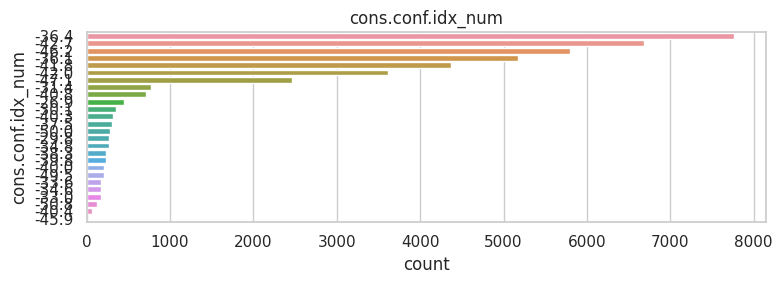


euribor3m_num value counts (%):
 euribor3m_num
4.857    6.96
4.962    6.34
4.963    6.04
4.961    4.62
4.856    2.94
4.964    2.85
1.405    2.84
4.965    2.60
4.864    2.53
4.960    2.46
4.968    2.41
4.959    2.17
4.860    2.17
4.855    2.04
4.076    2.00
1.266    1.99
4.859    1.91
4.120    1.84
4.858    1.78
4.153    1.68
Name: proportion, dtype: float64


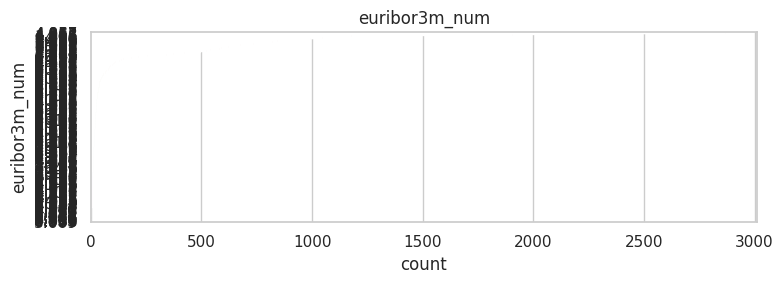


nr.employed_num value counts (%):
 nr.employed_num
5228.1    39.41
5099.1    20.72
5191.0    18.85
5195.8     8.94
5076.2     4.04
5017.5     2.60
4991.6     1.88
5008.7     1.58
4963.6     1.54
5023.5     0.42
5176.3     0.02
Name: proportion, dtype: float64


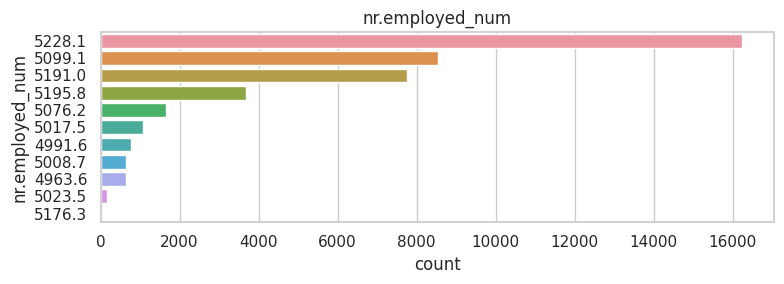


no_prior_contact value counts (%):
 no_prior_contact
1    96.32
0     3.68
Name: proportion, dtype: float64


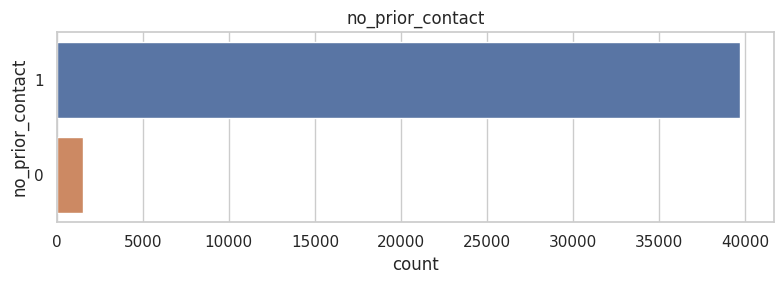


pdays_clean value counts (%):
 pdays_clean
3.0     28.98
6.0     27.19
4.0      7.79
9.0      4.22
2.0      4.03
7.0      3.96
12.0     3.83
10.0     3.43
5.0      3.04
13.0     2.38
11.0     1.85
1.0      1.72
15.0     1.58
14.0     1.32
8.0      1.19
0.0      0.99
16.0     0.73
17.0     0.53
18.0     0.46
22.0     0.20
Name: proportion, dtype: float64


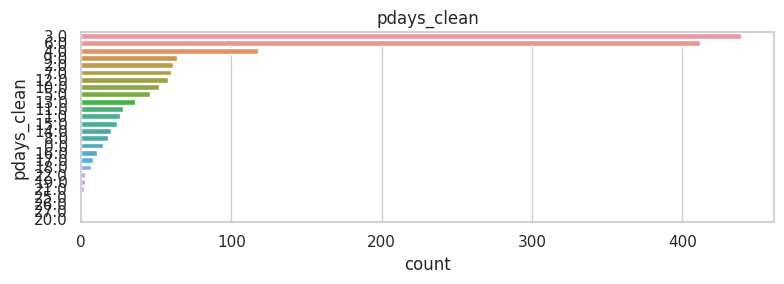

In [4]:
cat_cols = [c for c in df.columns if c not in num_cols + ['y']]
for c in cat_cols:
    vc = df[c].value_counts(normalize=True).mul(100).round(2)
    print(f'\n{c} value counts (%):\n', vc.head(20))
    plt.figure(figsize=(8,3))
    sns.countplot(y=c, data=df, order=df[c].value_counts().index)
    plt.title(c)
    plt.tight_layout()
    plt.show()


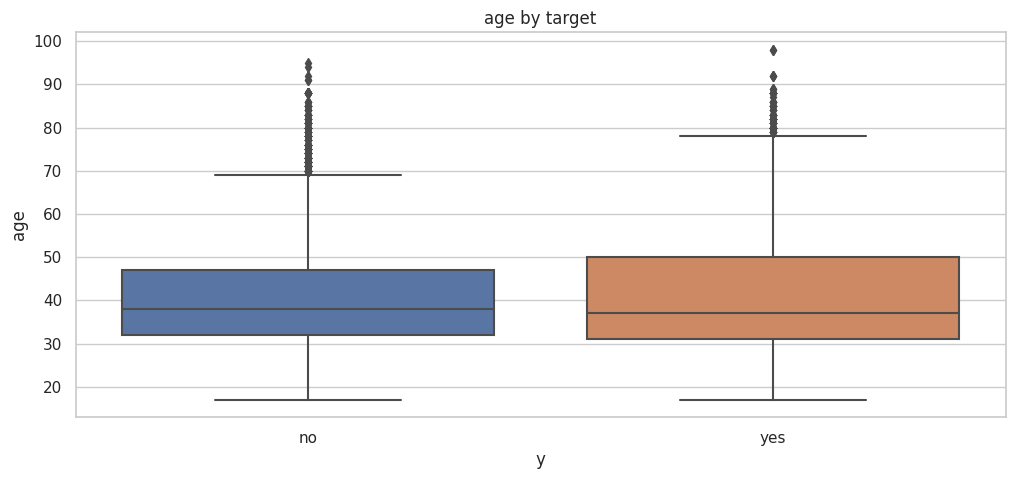

age t-test p-value: 1.805e-06


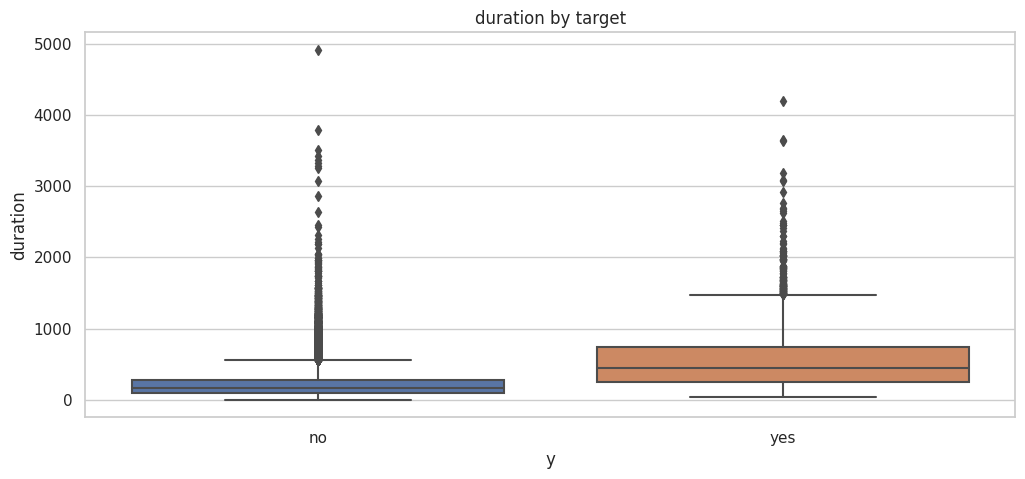

duration t-test p-value: 0.000e+00


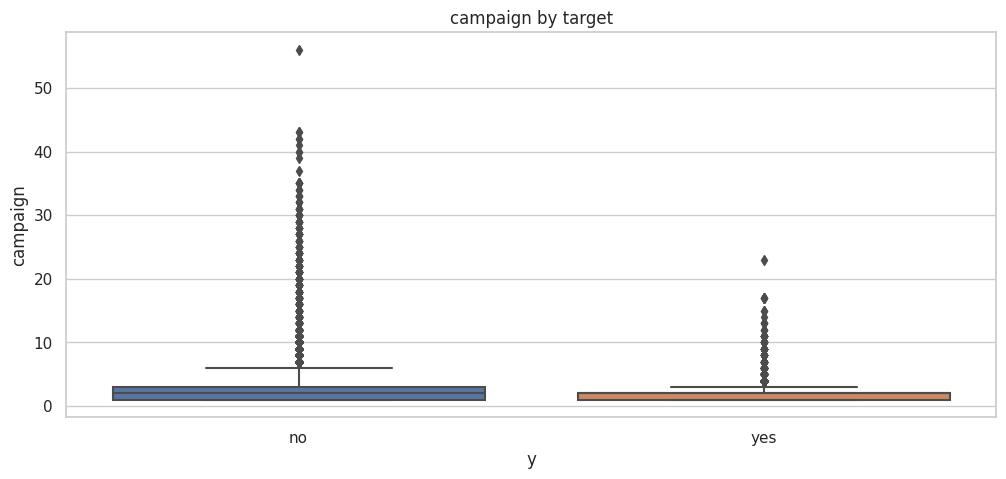

campaign t-test p-value: 4.100e-89


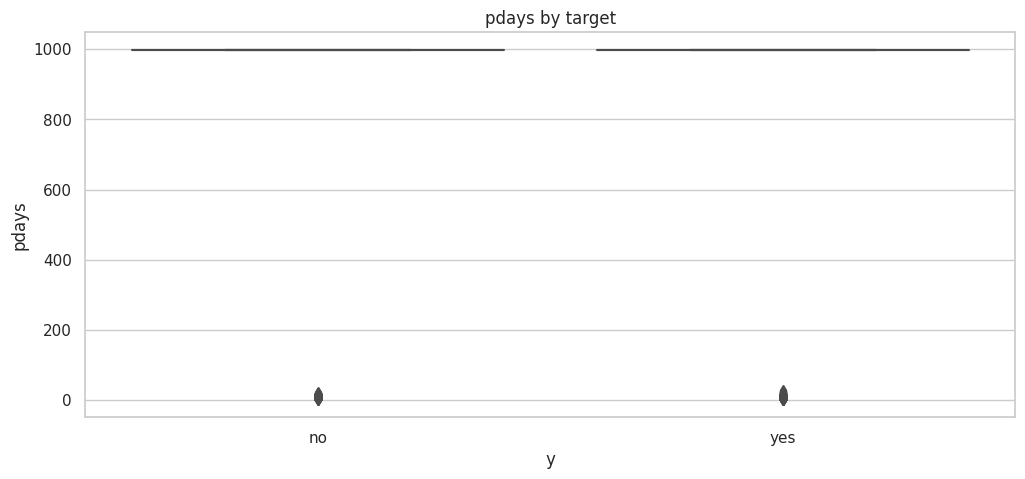

pdays t-test p-value: 1.663e-206


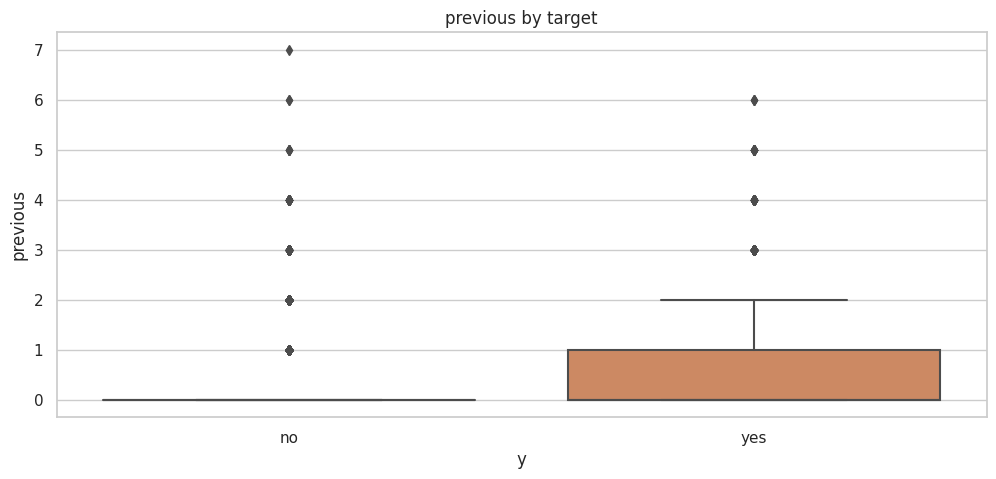

previous t-test p-value: 1.676e-161


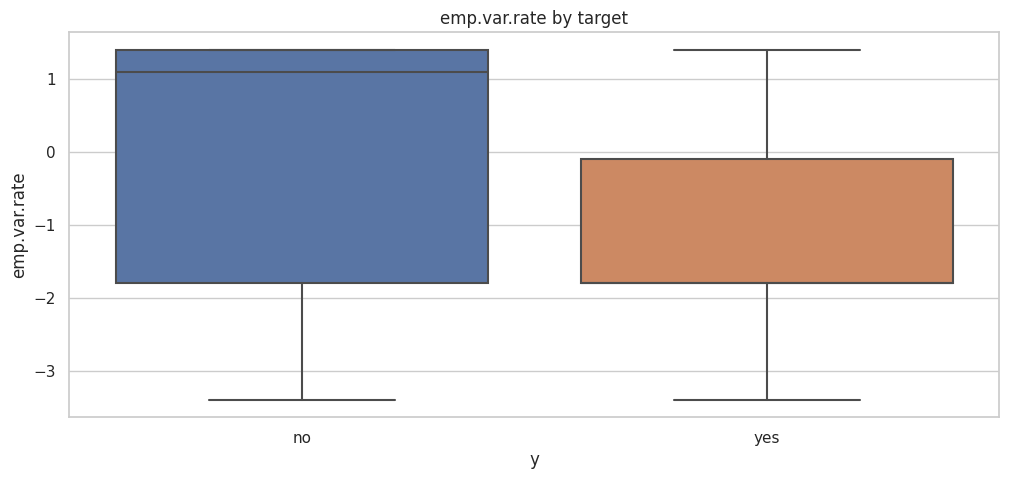

emp.var.rate t-test p-value: 0.000e+00


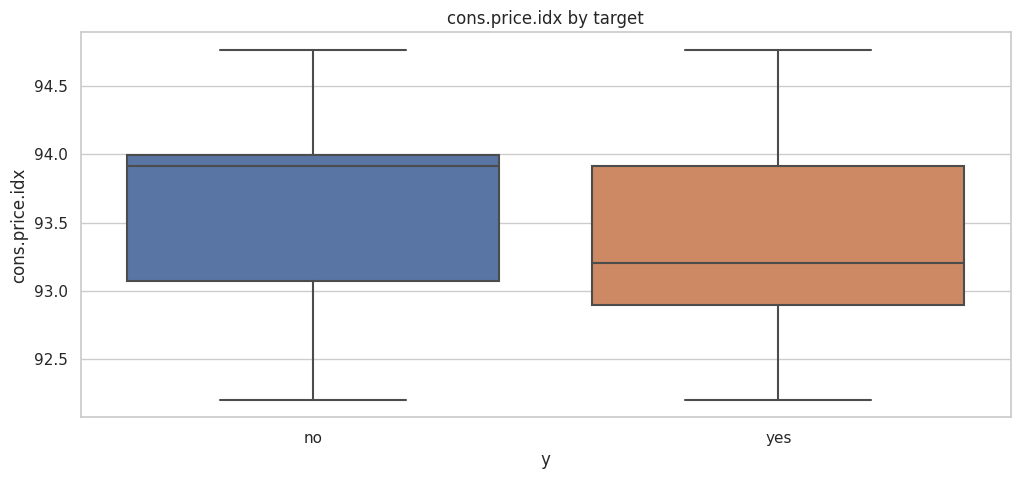

cons.price.idx t-test p-value: 6.917e-122


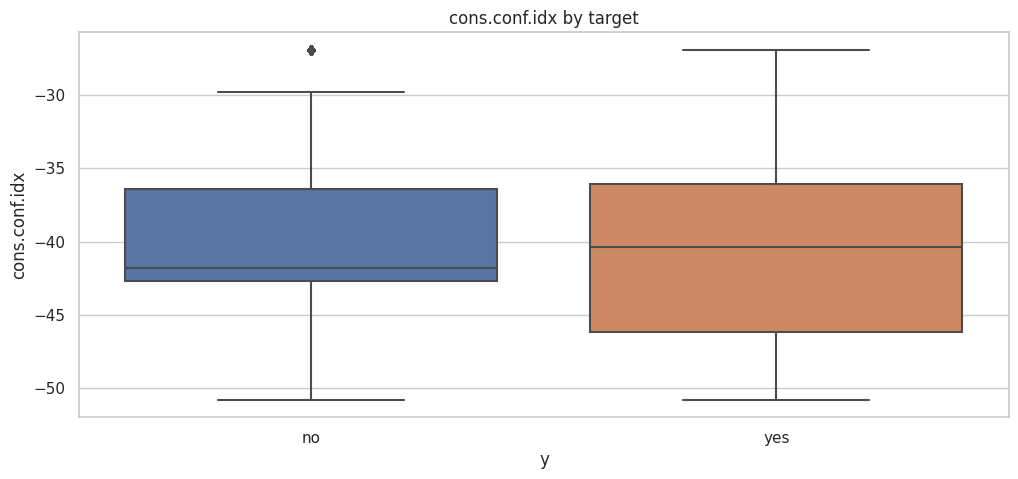

cons.conf.idx t-test p-value: 7.588e-18


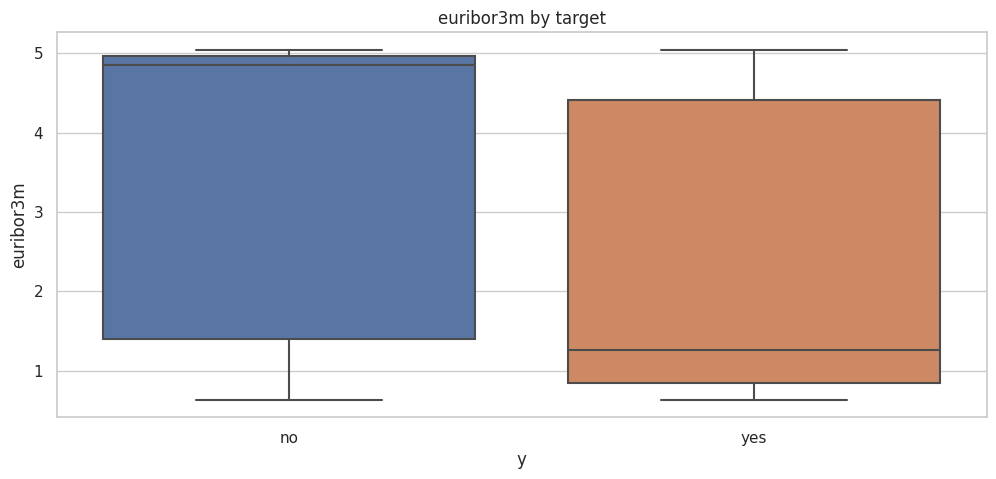

euribor3m t-test p-value: 0.000e+00


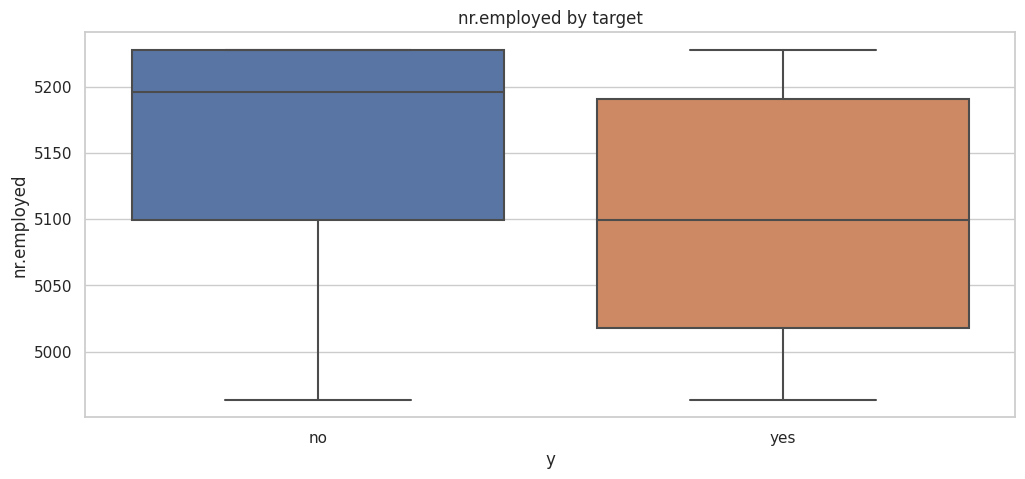

nr.employed t-test p-value: 0.000e+00

Top conversion rates for job:
 job
student          0.314286
retired          0.252326
unemployed       0.142012
admin.           0.129726
management       0.112175
unknown          0.112121
technician       0.108260
self-employed    0.104856
housemaid        0.100000
entrepreneur     0.085165
Name: y_bin, dtype: float64


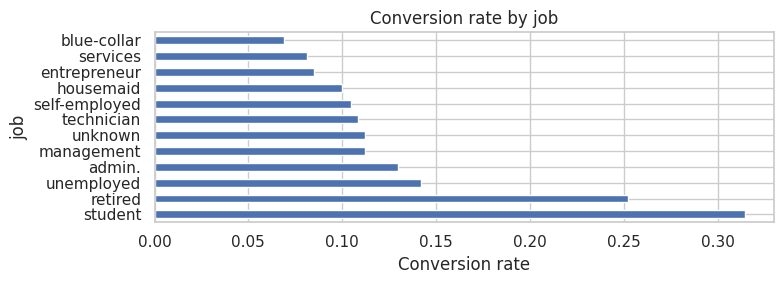


Top conversion rates for marital:
 marital
unknown     0.150000
single      0.140041
divorced    0.103209
married     0.101573
Name: y_bin, dtype: float64


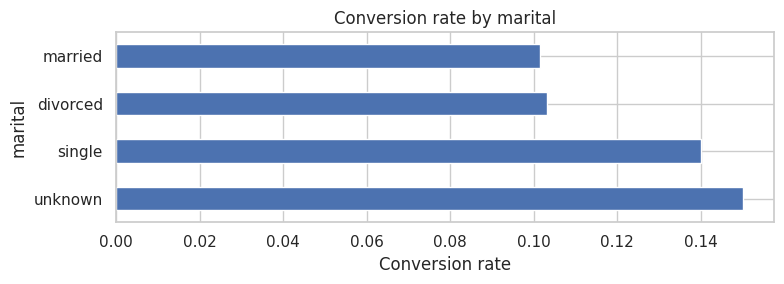


Top conversion rates for education:
 education
illiterate             0.222222
unknown                0.145003
university.degree      0.137245
professional.course    0.113485
high.school            0.108355
basic.4y               0.102490
basic.6y               0.082024
basic.9y               0.078246
Name: y_bin, dtype: float64


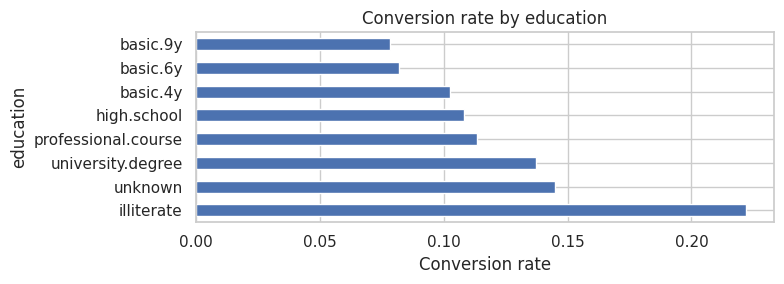


Top conversion rates for default:
 default
no         0.12879
unknown    0.05153
yes        0.00000
Name: y_bin, dtype: float64


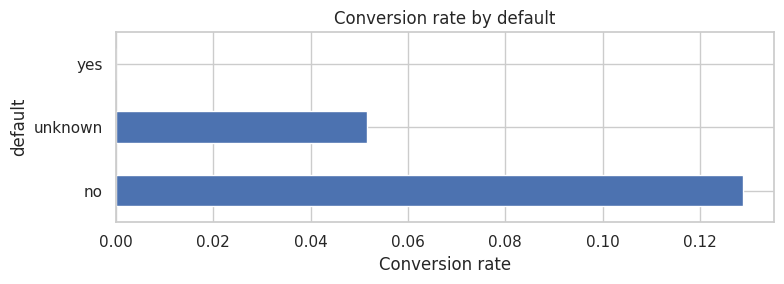


Top conversion rates for housing:
 housing
yes        0.116194
no         0.108796
unknown    0.108081
Name: y_bin, dtype: float64


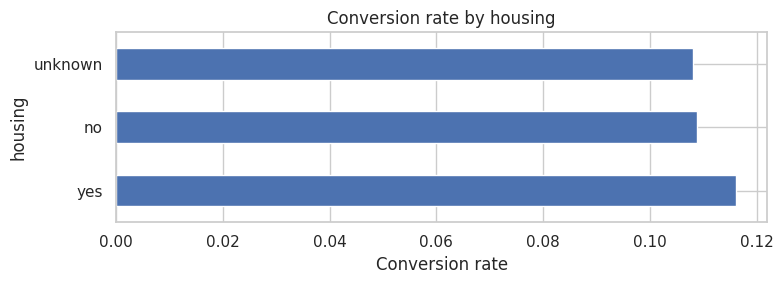


Top conversion rates for loan:
 loan
no         0.113402
yes        0.109315
unknown    0.108081
Name: y_bin, dtype: float64


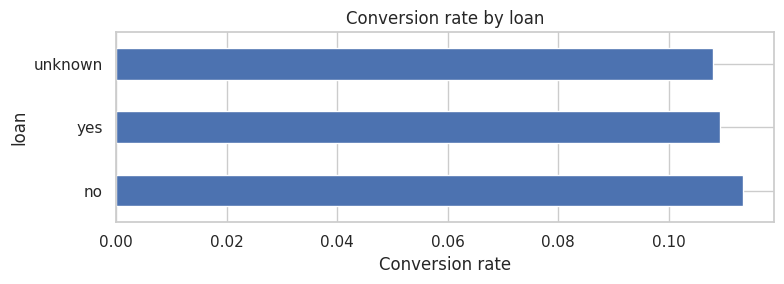


Top conversion rates for contact:
 contact
cellular     0.147376
telephone    0.052313
Name: y_bin, dtype: float64


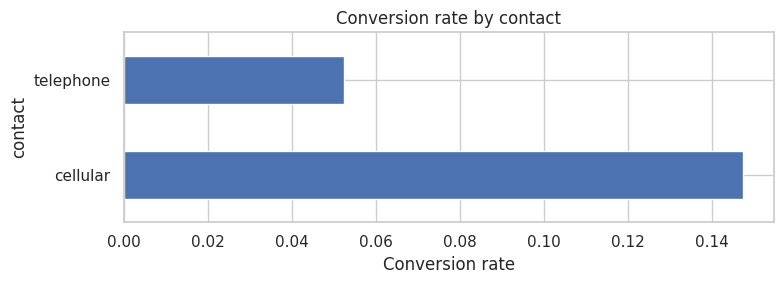


Top conversion rates for month:
 month
mar    0.505495
dec    0.489011
sep    0.449123
oct    0.438719
apr    0.204787
aug    0.106021
jun    0.105115
nov    0.101439
jul    0.090466
may    0.064347
Name: y_bin, dtype: float64


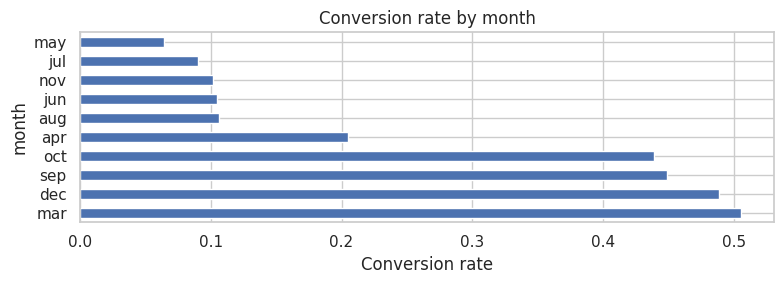


Top conversion rates for day_of_week:
 day_of_week
thu    0.121188
tue    0.117800
wed    0.116671
fri    0.108087
mon    0.099483
Name: y_bin, dtype: float64


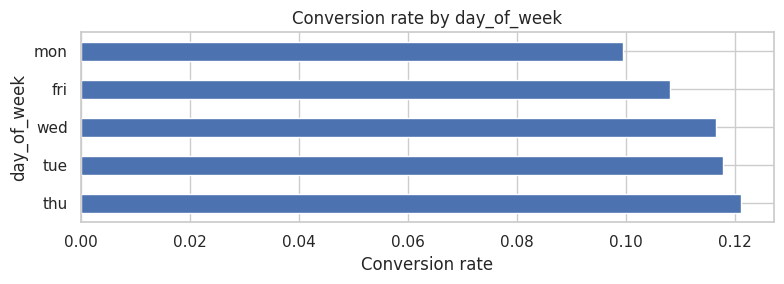


Top conversion rates for poutcome:
 poutcome
success        0.651129
failure        0.142286
nonexistent    0.088322
Name: y_bin, dtype: float64


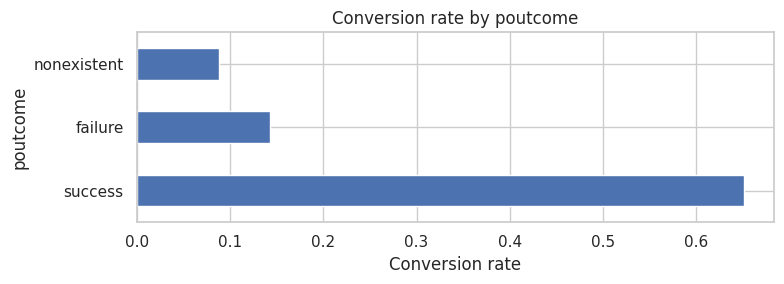


Top conversion rates for age_num:
 age_num
98    1.000000
89    1.000000
87    1.000000
92    0.750000
77    0.650000
82    0.647059
86    0.625000
80    0.580645
76    0.529412
65    0.522727
Name: y_bin, dtype: float64


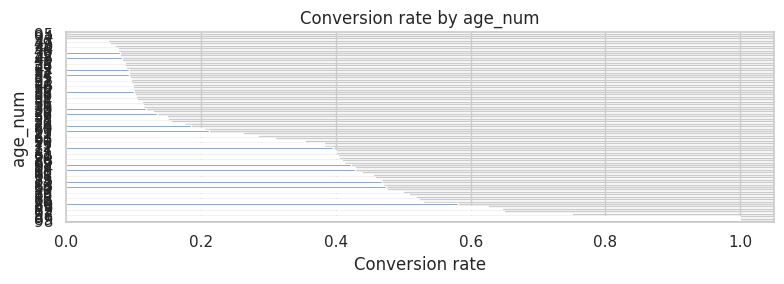


Top conversion rates for duration_num:
 duration_num
998     1.0
949     1.0
830     1.0
1613    1.0
959     1.0
1227    1.0
1228    1.0
1817    1.0
817     1.0
1232    1.0
Name: y_bin, dtype: float64


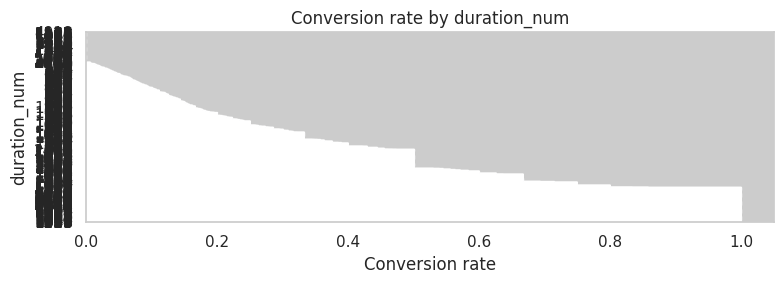


Top conversion rates for campaign_num:
 campaign_num
1     0.130371
2     0.114570
3     0.107471
4     0.093927
6     0.076609
5     0.075047
17    0.068966
11    0.067797
23    0.062500
7     0.060413
Name: y_bin, dtype: float64


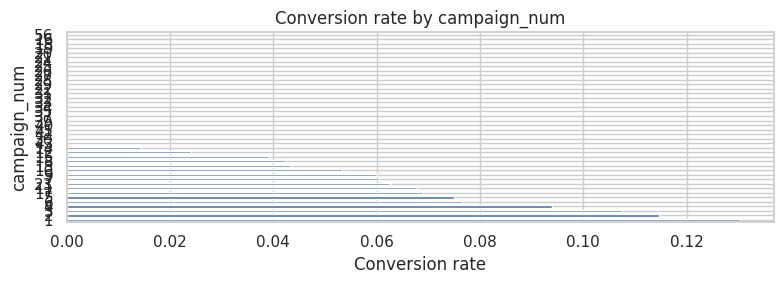


Top conversion rates for pdays_num:
 pdays_num
27    1.000000
26    1.000000
25    1.000000
21    1.000000
13    0.777778
6     0.701456
3     0.678815
15    0.666667
22    0.666667
0     0.666667
Name: y_bin, dtype: float64


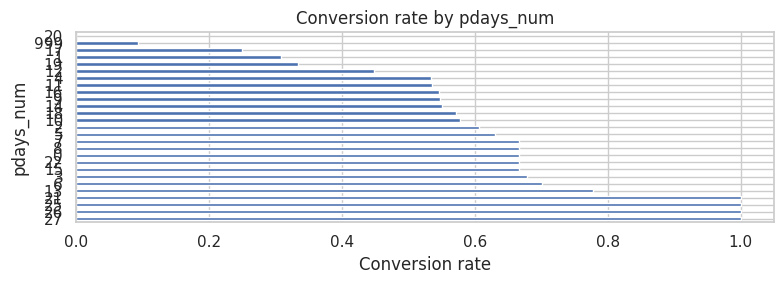


Top conversion rates for previous_num:
 previous_num
5    0.722222
6    0.600000
3    0.592593
4    0.542857
2    0.464191
1    0.212015
0    0.088322
7    0.000000
Name: y_bin, dtype: float64


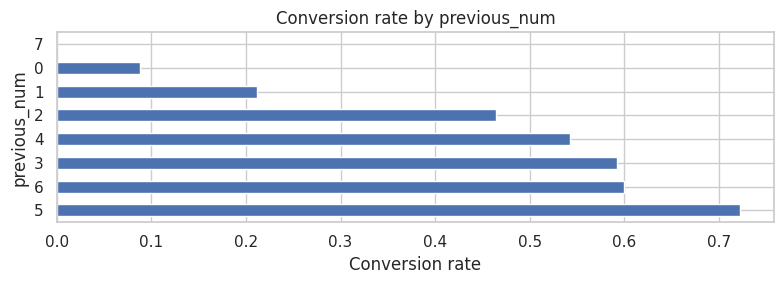


Top conversion rates for emp.var.rate_num:
 emp.var.rate_num
-1.7    0.521345
-3.0    0.511628
-1.1    0.474016
-3.4    0.423903
-2.9    0.357186
-1.8    0.159081
-0.2    0.100000
-0.1    0.062992
 1.4    0.053345
 1.1    0.030916
Name: y_bin, dtype: float64


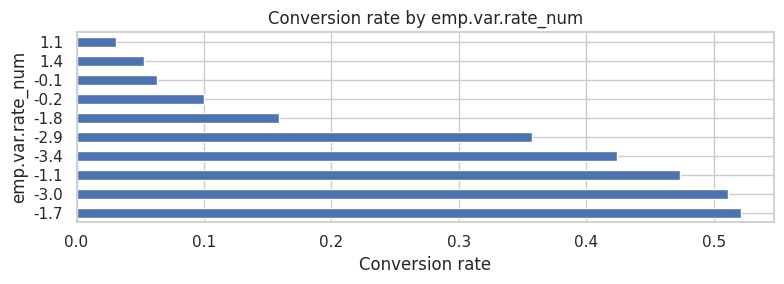


Top conversion rates for cons.price.idx_num:
 cons.price.idx_num
93.798    0.626866
93.876    0.575472
93.369    0.568182
94.215    0.565916
93.749    0.557471
94.027    0.515021
92.713    0.511628
94.199    0.495050
92.649    0.470588
94.055    0.467249
Name: y_bin, dtype: float64


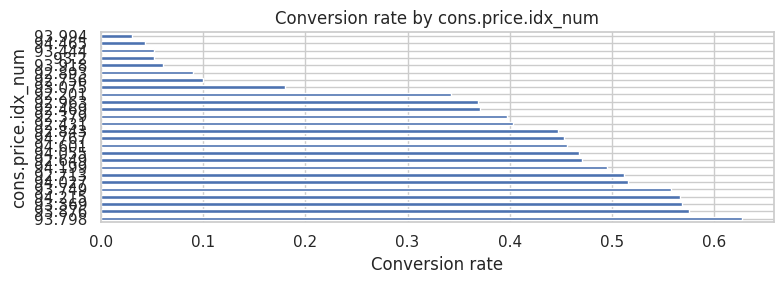


Top conversion rates for cons.conf.idx_num:
 cons.conf.idx_num
-40.4    0.626866
-40.0    0.575472
-34.8    0.568182
-40.3    0.565916
-34.6    0.557471
-38.3    0.515021
-33.0    0.511628
-37.5    0.495050
-30.1    0.470588
-39.8    0.467249
Name: y_bin, dtype: float64


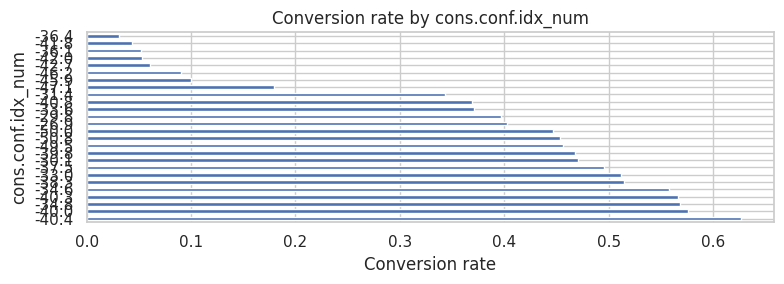


Top conversion rates for euribor3m_num:
 euribor3m_num
3.053    1.000000
0.688    1.000000
0.933    1.000000
0.870    0.923077
0.885    0.900000
0.755    0.857143
4.936    0.833333
0.637    0.833333
1.548    0.833333
0.697    0.826087
Name: y_bin, dtype: float64


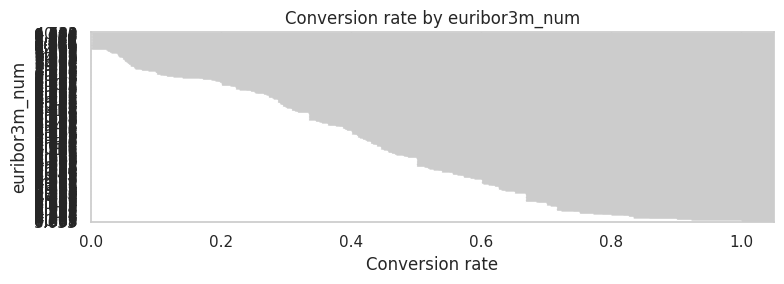


Top conversion rates for nr.employed_num:
 nr.employed_num
5008.7    0.567692
4991.6    0.521345
5023.5    0.511628
4963.6    0.474016
5017.5    0.423903
5076.2    0.357186
5099.1    0.127959
5176.3    0.100000
5195.8    0.062992
5228.1    0.053345
Name: y_bin, dtype: float64


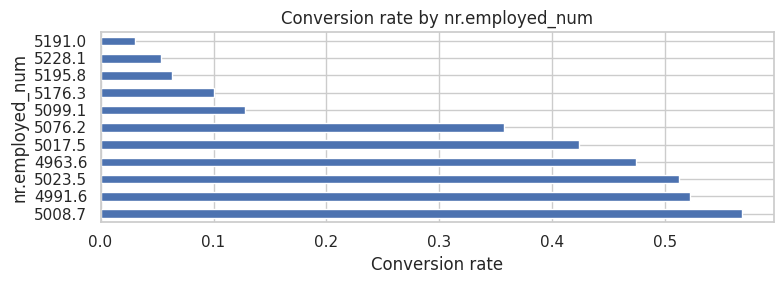


Top conversion rates for no_prior_contact:
 no_prior_contact
0    0.638284
1    0.092582
Name: y_bin, dtype: float64


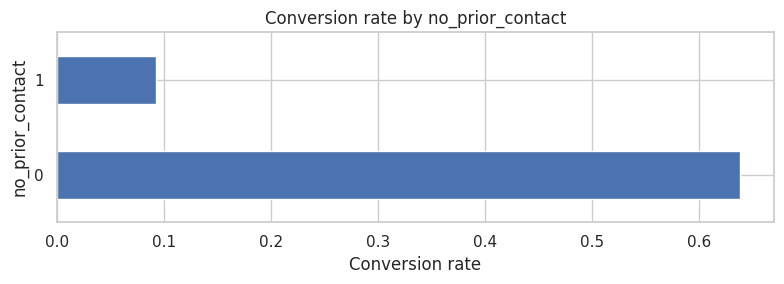


Top conversion rates for pdays_clean:
 pdays_clean
27.0    1.000000
21.0    1.000000
26.0    1.000000
25.0    1.000000
13.0    0.777778
6.0     0.701456
3.0     0.678815
15.0    0.666667
22.0    0.666667
0.0     0.666667
Name: y_bin, dtype: float64


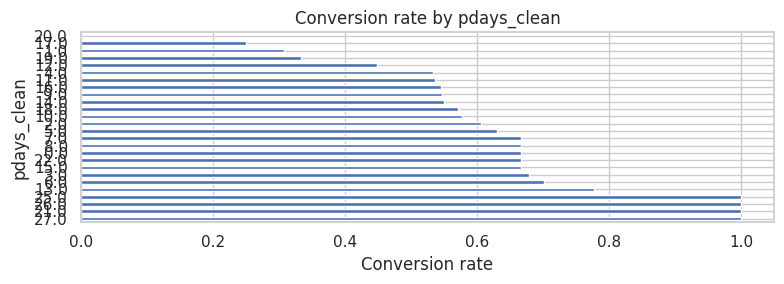

In [7]:
# Convert target to binary for calculations
df['y_bin'] = df['y'].map({'yes':1, 'no':0})

# Numerical vs target: compare distributions and t-tests
for c in num_cols:
    sns.boxplot(x='y', y=c, data=df)
    plt.title(f'{c} by target')
    plt.show()
    # t-test (non-parametric alternative could be used if distributions are non-normal)
    yes_vals = df.loc[df['y']=='yes', c]
    no_vals = df.loc[df['y']=='no', c]
    tstat, pval = stats.ttest_ind(yes_vals, no_vals, equal_var=False)
    print(f'{c} t-test p-value: {pval:.3e}')

# Categorical vs target: conversion rates per category
for c in cat_cols:
    conv = df.groupby(c)['y_bin'].mean().sort_values(ascending=False)
    print(f'\nTop conversion rates for {c}:\n', conv.head(10))
    plt.figure(figsize=(8,3))
    conv.plot(kind='barh')
    plt.title(f'Conversion rate by {c}')
    plt.xlabel('Conversion rate')
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


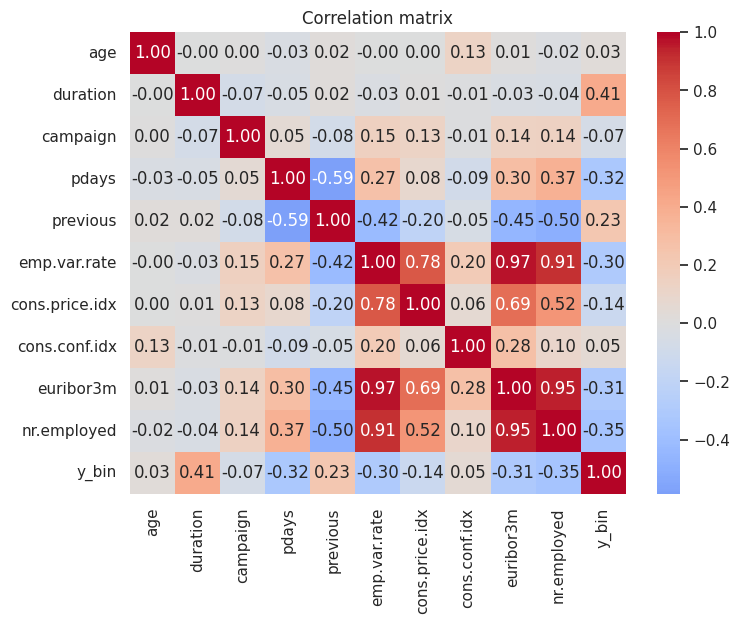

In [8]:
# Correlation matrix for numerical features
corr = df[num_cols + ['y_bin']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation matrix')
plt.show()


In [9]:
# Cross-tab examples: job vs education, job vs poutcome
ct1 = pd.crosstab(df['job'], df['education'], normalize='index').round(3)
display(ct1.head())

ct2 = pd.crosstab(df['job'], df['poutcome'], normalize='index').round(3)
display(ct2.head())


education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,0.007,0.014,0.048,0.319,0.000,0.035,0.552,0.024
blue-collar,0.250,0.154,0.392,0.095,0.001,0.049,0.010,0.049
entrepreneur,0.094,0.049,0.144,0.161,0.001,0.093,0.419,0.039
housemaid,0.447,0.073,0.089,0.164,0.001,0.056,0.131,0.040
management,0.034,0.029,0.057,0.102,0.000,0.030,0.706,0.042


poutcome,failure,nonexistent,success
job,,,
admin.,0.105,0.854,0.041
blue-collar,0.096,0.891,0.013
entrepreneur,0.106,0.877,0.017
housemaid,0.070,0.894,0.036
management,0.113,0.854,0.032


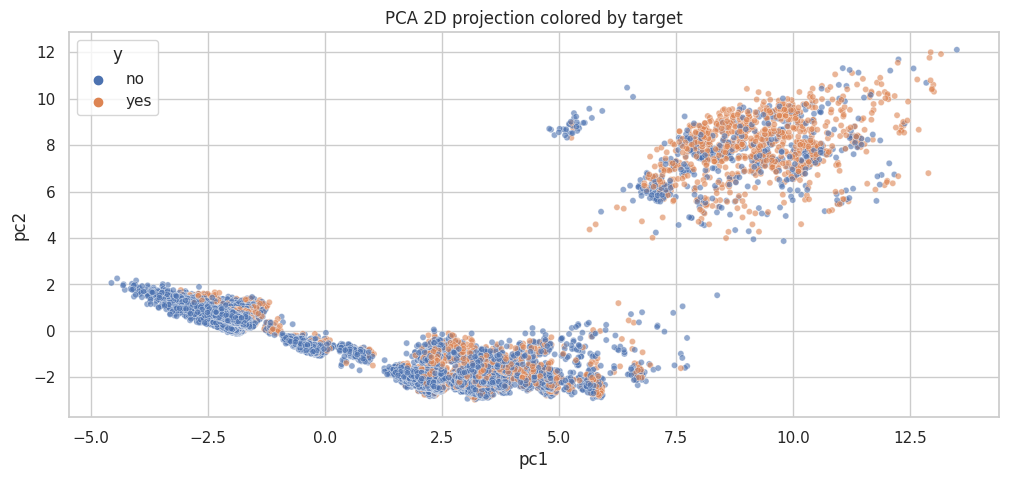

Explained variance ratio (first 5 PCs): [0.26246104 0.12820476]


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Simple encoding for visualization: label encode categoricals (for PCA only)
df_viz = df.copy()
le = LabelEncoder()
for c in cat_cols:
    df_viz[c+'_le'] = le.fit_transform(df_viz[c])

viz_cols = num_cols + [c+'_le' for c in cat_cols]
X_viz = StandardScaler().fit_transform(df_viz[viz_cols])

pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_viz)
df_viz['pc1'] = pc[:,0]; df_viz['pc2'] = pc[:,1]

sns.scatterplot(x='pc1', y='pc2', hue='y', data=df_viz, alpha=0.6, s=20)
plt.title('PCA 2D projection colored by target')
plt.show()

print('Explained variance ratio (first 5 PCs):', pca.explained_variance_ratio_[:5])


In [12]:
from scipy.stats import chi2_contingency

chi_results = {}
for c in cat_cols:
    table = pd.crosstab(df[c], df['y'])
    chi2, p, dof, ex = chi2_contingency(table)
    chi_results[c] = p

pd.Series(chi_results).sort_values()


nr.employed_num        0.000000e+00
euribor3m_num          0.000000e+00
cons.conf.idx_num      0.000000e+00
cons.price.idx_num     0.000000e+00
emp.var.rate_num       0.000000e+00
previous_num           0.000000e+00
month                  0.000000e+00
pdays_num              0.000000e+00
poutcome               0.000000e+00
no_prior_contact       0.000000e+00
duration_num           0.000000e+00
age_num               4.137347e-295
job                   4.189763e-199
contact               1.525986e-189
default                5.161958e-89
education              3.305189e-38
marital                2.068015e-26
campaign_num           3.881754e-26
day_of_week            2.958482e-05
pdays_clean            2.210410e-04
housing                5.829448e-02
loan                   5.786753e-01
dtype: float64

In [14]:
# Example: does mean balance differ by job?
groups = [group['age'].values for name, group in df.groupby('job')]
fstat, pval = stats.f_oneway(*groups)
fstat, pval


(1279.977194804442, 0.0)

In [16]:
# Simple IQR-based outlier detection for balance and duration
def iqr_outliers(series):
    q1 = series.quantile(0.25); q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr; upper = q3 + 1.5*iqr
    return ((series < lower) | (series > upper)).sum()

for c in ['age','duration']:
    print(c, 'outliers count:', iqr_outliers(df[c]))


age outliers count: 469
duration outliers count: 2963


In [20]:
# Example transform pipeline
df_prep = df.copy()
# pdays handling
df_prep['no_prior_contact'] = (df_prep['pdays'] == 999).astype(int)
df_prep['pdays_clean'] = df_prep['pdays'].replace(999, -1)

# log transform skewed numeric
for c in ['duration']:
    df_prep[c+'_log'] = np.log1p(df_prep[c].clip(lower=0))

# One-hot encode categoricals
X = pd.get_dummies(df_prep[cat_cols + ['no_prior_contact'] + ['pdays_clean'] + ['duration_log','age','campaign','previous']], drop_first=True)
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# choose k by silhouette
scores = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))
best_k = K[np.argmax(scores)]
print('Best k by silhouette:', best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_scaled)
df['cluster'] = km.labels_

# Profile clusters
profile = df.groupby('cluster').agg(
    count=('age','size'),
    median_age=('age','median'),
    median_duration=('duration','median'),
    conversion_rate=('y_bin','mean'),
    avg_campaign=('campaign','mean')
).sort_values('conversion_rate', ascending=False)
display(profile)


Best k by silhouette: 2


,count,median_age,median_duration,conversion_rate,avg_campaign
cluster,,,,,
1,1515,37.0,253.0,0.638284,1.822442
0,39673,38.0,177.0,0.092582,2.596048


In [24]:
# Safe numeric conversion for all num_cols
def to_numeric_safe(series):
    s = series.astype(str).str.replace(',', '', regex=False).str.strip()
    return pd.to_numeric(s, errors='coerce')

for c in num_cols:
    df[c] = to_numeric_safe(df[c])

# Handle pdays sentinel (999 means "no prior contact")
df['no_prior_contact'] = (df['pdays'] == 999).astype(int)
df['pdays'] = df['pdays'].replace(999, np.nan)


In [27]:
# Numeric imputation
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Categorical imputation
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])


In [28]:
from sklearn.feature_selection import mutual_info_classif

X_mi = pd.get_dummies(df[cat_cols + num_cols + ['no_prior_contact']], drop_first=True)
y_mi = df['y_bin'].values

mi = mutual_info_classif(X_mi, y_mi, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)

print(mi_series.head(20))


duration_num            0.077859
duration                0.076698
euribor3m               0.073779
euribor3m_num           0.072360
cons.price.idx          0.071358
cons.conf.idx_num       0.070892
cons.conf.idx           0.069595
cons.price.idx_num      0.069527
nr.employed             0.063106
nr.employed_num         0.062272
emp.var.rate            0.057378
emp.var.rate_num        0.056971
no_prior_contact        0.040163
pdays_num               0.038572
no_prior_contact        0.038386
pdays                   0.031899
poutcome_success        0.028229
pdays_clean             0.025689
poutcome_nonexistent    0.022740
previous_num            0.020077
dtype: float64
